# Traditional machine learning model validation 

This notebook can be used to validate the traditional machine learning models. 

In [1]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_MODELS, PATH_DATA_PROCESSED_ML, PATH_METADATA

# 1. Preparing data and helper functions

## Load data

In [3]:
%%time

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_ML)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_ML, file_name))[0] for file_name in fnmatch.filter(file_names, "*.h5")]

# Step 3: Load the features
frames = []

for idx, feature_file in enumerate(files):
    df_features = pd.read_hdf(feature_file + ".h5")
    df_metadata = pd.read_csv(feature_file.replace("extracted_features_", "processed_data_") + ".csv")
    
    # Step 4: Assign labels and age group
    df_features['label'] = df_metadata['age_months'][0]
    df_features['age_group'] = df_metadata['age_group'][0]
    
    # Step 5: Assign subject code
    df_features['code'] = df_metadata['code'][0]
    frames.append(df_features)

df = pd.concat(frames) 

# Step 6: List all the unique subject IDs
subject_ids = sorted(list(set(df["code"].tolist())))

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

# Step 7: Split the DataFrames into train, validation and test
df_train = df[df['code'].isin(IDs_train)]
df_val = df[df['code'].isin(IDs_val)]
df_test = df[df['code'].isin(IDs_test)]

feature_names = df.columns.values

CPU times: user 40.7 s, sys: 25.8 s, total: 1min 6s
Wall time: 1min 40s


In [4]:
X_train = df_train.drop(['label', 'code', 'age_group'], axis=1).reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)
codes_train = df_train['code'].reset_index(drop=True)
agegroups_train = df_train['age_group'].reset_index(drop=True)

X_val = df_val.drop(['label', 'code', 'age_group'], axis=1).reset_index(drop=True)
y_val = df_val['label'].reset_index(drop=True)
codes_val = df_val['code'].reset_index(drop=True)
agegroups_val = df_val['age_group'].reset_index(drop=True)

X_test = df_test.drop(['label', 'code', 'age_group'], axis=1).reset_index(drop=True)
y_test = df_test['label'].reset_index(drop=True)
codes_test = df_test['code'].reset_index(drop=True)
agegroups_test = df_test['age_group'].reset_index(drop=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

# MARK: reducing from 64 bit float to 32 bit float, to reduce memory usage
X_train = pd.DataFrame(scaler.fit_transform(X_train)).astype('float32')
X_val = pd.DataFrame(scaler.fit_transform(X_val)).astype('float32')
X_test = pd.DataFrame(scaler.fit_transform(X_test)).astype('float32')

For the ML models, the data set has been split into train and test. Only for the simple feedforward neural network, we've also used a validation set (taken from the train set). The test set remains the same.

In [5]:
X_train_val = pd.concat([X_train, X_val]).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val]).reset_index(drop=True)
codes_train_val = pd.concat([codes_train, codes_val]).reset_index(drop=True)
agegroups_train_val = pd.concat([agegroups_train, agegroups_val]).reset_index(drop=True)

In [6]:
# del(file_names, files, df, frames, df_features, df_metadata, df_train, df_test, df_val, X_train, X_val, X_test, X_train_val)

In [ ]:
del(file_names, files, df, frames, df_features, df_metadata, df_train, df_test, df_val)

## Load additional data

In [ ]:
vocabulary_filename = "CDIinfo_combined.csv"
vocabulary_dataframe = pd.read_csv(os.path.join(PATH_METADATA, vocabulary_filename))

In [ ]:
vocabulary_dataframe.head()

In [ ]:
dyslexia_filename = "Screening_children5a_summary_new.txt"
dyslexia_dataframe = pd.read_csv(os.path.join(PATH_METADATA, dyslexia_filename), delimiter = "\t")
dyslexia_dataframe = dyslexia_dataframe[['id_child', 'dyslexicAtMidGroup3DDP']]
dyslexia_dataframe = dyslexia_dataframe.loc[dyslexia_dataframe['dyslexicAtMidGroup3DDP'].isin(['0', '1'])]

In [ ]:
dyslexia_dataframe.head(10)

## Helper functions for validation (old)

In [79]:
def test_model_separate_epochs(model, X_test, y_test, codes_test):
    """Takes in the IDs of the test subjects, predicts the ages on individual epochs per subject per age group. 
        Final prediction for the subject in an age group is the median of all predictions."""
    
    y_true = []
    y_pred = []
    
    df_codes_test = pd.DataFrame(codes_test)
    IDs_test = list(set(codes_test))
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Get the indices in the dataframes for the subject with ID
        idx = df_codes_test.loc[df_codes_test['code'] == ID].index.tolist()
        
        # Step 3: Get the different ages we have epochs from of this subject
        ages_subject = list(set(y_test.loc[idx]))
        
        # Step 4: Only look at the epochs at a specific age
        for true_age in ages_subject:
            idx_age_group = y_test[idx][y_test == true_age].index.tolist()
            
            # Step 5: Predict age for all epochs at that age and take median as final prediction for all of them
            predicted_ages = model.predict(X_test.iloc[idx_age_group]).flatten()
            predicted_age = np.median(predicted_ages)
            
            y_pred.append(predicted_age)
            y_true.append(true_age)
            
    return y_true, y_pred

In [80]:
from sklearn.utils import resample

def test_model_separate_epochs_bootstrapped(model, X_test, y_test, codes_test):
    """Takes in the IDs of the test subjects, predicts the ages on individual epochs per subject per age group. 
        Final prediction for the subject in an age group is the median of all predictions."""
    
    y_true = []
    y_pred = []
    y_pred_epochs = []
    y_pred_bootstrap = []
    
    df_codes_test = pd.DataFrame(codes_test)
    IDs_test = list(set(codes_test))
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Get the indices in the dataframes for the subject with ID
        idx = df_codes_test.loc[df_codes_test['code'] == ID].index.tolist()
        
        # Step 3: Get the different ages we have epochs from of this subject
        ages_subject = list(set(y_test.loc[idx]))
        
        # Step 4: Only look at the epochs at a specific age
        for true_age in ages_subject:
            idx_age_group = y_test[idx][y_test == true_age].index.tolist()
            
            # Step 5: Predict age for all epochs at that age and take median as final prediction for all of them
            predicted_ages = model.predict(X_test.iloc[idx_age_group]).flatten()
            predicted_age = np.median(predicted_ages)
            
            # Step 6: Bootstrapping, predict 100 ages on resampled epochs
            predicted_ages_bootstrapped = []
            
            for i in range(100):
                resampled_ages = resample(predicted_ages)
                predicted_age_bootstr = np.median(resampled_ages)
                predicted_ages_bootstrapped.append(predicted_age_bootstr)
                
            y_true.append(true_age)            
            y_pred.append(predicted_age)
            y_pred_epochs.append(predicted_ages)
            y_pred_bootstrap.append(predicted_ages_bootstrapped)
            
    return y_true, y_pred, y_pred_epochs, y_pred_bootstrap

In [81]:
from scipy.stats import pearsonr

def error_stability_averaged_epochs(model, X_test, y_test, codes_test):
    """Takes in the IDs of the test subjects, predicts the ages on individual epochs per subject per age group. 
        Final prediction for the subject in an age group is the median of all predictions. Stability calculated based on this."""
    
    errors_time_N = []
    errors_time_N1 = []
    
    df_codes_test = pd.DataFrame(codes_test)
    IDs_test = list(set(codes_test))
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Get the indices in the dataframes for the subject with ID
        idx = df_codes_test.loc[df_codes_test['code'] == ID].index.tolist()
        
        # Step 3: Get the different ages we have epochs from of this subject
        ages_subject = sorted(list(set(y_test.loc[idx])))
        
        if len(ages_subject) == 1:
            continue
        
        prev_prediction_error = None
        curr_prediction_error = None
        
        # Step 4: Only look at the epochs at a specific age
        for true_age in ages_subject:
            prev_prediction_error = curr_prediction_error
            
            idx_age_group = y_test[idx][y_test == true_age].index.tolist()
            
            # Step 5: Predict age for all epochs at that age and take median as final prediction for all of them
            predicted_ages = model.predict(X_test.iloc[idx_age_group]).flatten()
            curr_prediction_error = np.median(predicted_ages) - true_age
            
            # Step 6: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
#                 print(f"Predicted age: {np.median(predicted_ages)}, true age: {true_age}")
#                 print(f"Prediction error at N: {prev_prediction_error}, and N+1: {curr_prediction_error}")
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)
                
    # Step 7: Look at correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
#     print(f"Pearsons correlation: {corr:.3f}")
    
    return corr, errors_time_N, errors_time_N1

In [84]:
from scipy.stats import pearsonr

def correlation_brainage_vocabulary(model, X_test, y_test, codes_test, agegroups_test, age_months=17, productive=True):
    category = "productive" if productive else "receptive"
    model.verbose = False
    
    brain_ages = []
    vocabulary_sizes = []
    
    df_codes_test = pd.DataFrame(codes_test)
    df_agegroups_test = pd.DataFrame(agegroups_test)
    df_codes_test = pd.concat([df_codes_test, df_agegroups_test], axis=1)
    
    IDs_test = list(set(codes_test))
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Get the indices in the dataframes for the subject with ID within this age group
        idx = df_codes_test.loc[df_codes_test['code'] == ID].loc[df_codes_test['age_group'] == age_months].index.tolist()        
        
        if len(idx) == 0:
            # No EEG data for this subject in this age group
            continue
        
        # Step 3: Determine whether we have vocabulary information or not
        vocabulary_size = vocabulary_dataframe.loc[vocabulary_dataframe['code'] == ID].loc[vocabulary_dataframe['age_months'] == age_months][category].values
        vocabulary_size = vocabulary_size[0] if len(vocabulary_size) > 0 else None
        
        if vocabulary_size is None:
            # No vocabulary data for this subject in this age group
            continue
        
        true_age = sorted(list(set(y_test.iloc[idx])))[0]

        # Step 4: Predict age for all epochs at that age and take median as final prediction for all of them
        predicted_ages = model.predict(X_test.iloc[idx]).flatten()
        prediction_error = np.median(predicted_ages) - true_age
        
        brain_ages.append(prediction_error)
        vocabulary_sizes.append(vocabulary_size)
                
    # Step 5: Look at correlation between prediction error and vocabulary
    print(f"Number of data points: {len(brain_ages)}")
    corr, _ = pearsonr(brain_ages, vocabulary_sizes)
    print(f"Pearsons correlation: {corr:.3f}")
    
    return corr, brain_ages, vocabulary_sizes

In [87]:
def distributions_brainage_dyslexia(model, X_test, y_test, codes_test, agegroups_test, age_months=17):
    
    brain_ages_dyslexia = []
    brain_ages_no_dyslexia = []
    
    df_codes_test = pd.DataFrame(codes_test)
    df_agegroups_test = pd.DataFrame(agegroups_test)
    df_codes_test = pd.concat([df_codes_test, df_agegroups_test], axis=1)
    
    IDs_test = list(set(codes_test))
    
    # Step 1: Iterate over subjects
    for ID in IDs_test:
        
        # Step 2: Get the indices in the dataframes for the subject with ID within this age group
        idx = df_codes_test.loc[df_codes_test['code'] == ID].loc[df_codes_test['age_group'] == age_months].index.tolist()        
        
        if len(idx) == 0:
            continue
        
        # Step 3: Determine whether we have dyslexia information
        dyslexia = dyslexia_dataframe.loc[dyslexia_dataframe['id_child'] == str(ID).zfill(3)]['dyslexicAtMidGroup3DDP'].values
        dyslexia = dyslexia[0] if len(dyslexia) > 0 else None
        
        if dyslexia is None:
            continue
        
        true_age = sorted(list(set(y_test.iloc[idx])))[0]

        # Step 4: Predict age for all epochs at that age and take median as final prediction for all of them
        predicted_ages = model.predict(X_test.iloc[idx]).flatten()
        prediction_error = np.median(predicted_ages) - true_age
        
        if int(dyslexia) == 1:
            brain_ages_dyslexia.append(prediction_error)
        else:
            brain_ages_no_dyslexia.append(prediction_error)
    
    return brain_ages_dyslexia, brain_ages_no_dyslexia

In [88]:
def confidence_interval(y_pred, y_pred_bootstrap, confidence=0.95):
    tail = (100 - (confidence * 100)) / 2
    
    d = [(pred - y_pred) for pred in y_pred_bootstrap]
    
    low = y_pred - np.percentile(d, (100- tail))
    high = y_pred - np.percentile(d, tail)
          
    CI = (low, high)
    return CI

In [89]:
def determine_retrieval_rate(y_pred, y_pred_bootstrap, interval=0.95, threshold=0.2):
    "Interval equal to 0.5 uses the interquartile range"
    
    ranges = []

    for i in range(len(y_pred)):
        CI = confidence_interval(y_pred[i], y_pred_bootstrap[i], interval)
        ranges.append(CI[1] - CI[0])

    ranges_retrieved = [val for val in ranges if val <= threshold]
    retrieval_rate = len(ranges_retrieved)/len(ranges)
    return retrieval_rate

In [90]:
def determine_IQR_for_rate(y_pred, y_pred_bootstrap, max_threshold=3, step=-0.001, desired_rate=0.8, interval=0.5):
    "Interval equal to 0.5 calculates interquartile range"
    
    thresholds = np.arange(max_threshold, 0, step)
    retrieval_rates = []
    
    for t in thresholds:
        rate = determine_retrieval_rate(y_pred, 
                                        y_pred_bootstrap,
                                        interval=interval, 
                                        threshold=t)
        retrieval_rates.append(rate)
    
    
    # Indices for retrieval rate = 1, except last
    rates_remove_idx = [i for i, e in enumerate(retrieval_rates) if e == 1]
    if len(rates_remove_idx) > 0:
        rates_remove_idx.pop()
        
    retrieval_rates = [e for i, e in enumerate(retrieval_rates) if i not in rates_remove_idx]
    thresholds = [e for i, e in enumerate(thresholds) if i not in rates_remove_idx]
    
    idx = np.abs(np.asarray(retrieval_rates) - desired_rate).argmin()
    
#     print(f"For desired retrieval rate {desired_rate}, the IQR is approx. {thresholds[idx]}.")
#     print(f"Retrieval rate used is {retrieval_rates[idx]}")
    
    return thresholds, retrieval_rates, idx   

## Helper functions (New)

Below are the same functions as above (i.e. same results), but written in a cleaner way that does not recalculate/predict unnecessarily.

In [ ]:
# New method

from sklearn.utils import resample

def make_predictions_bootstrapped(model, X_test, y_test, codes_test, agegroups_test):
    """Takes in the loaded model, the features (X_test) and true age (y_test), the subject IDs (codes_test) and
        the age group of the subject (agegroups_test). It then makes (bootstrapped) predictions for each subject
        for all ages. 
        
        Returns a DataFrame with the following columns:
        code, age_group, true_age, predicted_age, predicted_age_1, ... predicted_age_100
        The predicted_age_N columns contain the predictions on the resampled features. """
    
    # Step 1: Make empty DataFrame to store the predictions in
    column_names = ["code", "age_group", "true_age", "predicted_age"]
    for i in range(100):
        column_names.append(f"predicted_age_{i+1}")
    
    df_pred = pd.DataFrame(columns = column_names)
    
    # Step 2: Data processing steps and check the unique IDs
    df_codes_test = pd.DataFrame(codes_test)
    df_agegroups_test = pd.DataFrame(agegroups_test)
    df_codes_test = pd.concat([df_codes_test, df_agegroups_test], axis=1)

    IDs_test = list(set(codes_test))
    
    # Step 3: Iterate over subjects
    for ID in IDs_test:
        
        # Step 4: Get the indices for all rows in the DataFrames of this subject (with this code)
        idx = df_codes_test.loc[df_codes_test['code'] == ID].index.tolist()
        
        # Step 5: Determine the different ages of the subject we have data of
        all_ages_subject = sorted(list(set(y_test.loc[idx])))
        
        # Step 6: Look at the data of one age at a time, loop over it
        for true_age in all_ages_subject:
            
            # Step 7: Get the indices for all rows in the DataFrames of this subject at this specific age
            idx_this_age = y_test[idx][y_test == true_age].index.tolist()
            
            # Step 8: Check the age group (i.e. 11, 17, 23  instead of 10.98, 17.1, 22.78) of the subject
            age_group = df_codes_test.iloc[idx_this_age]['age_group'].values[0]
            
            # Step 9: Predict age for all epochs at that age and take median as final prediction for all of them
            predicted_ages = model.predict(X_test.iloc[idx_this_age]).flatten()
            predicted_age = np.median(predicted_ages)
            
            # Step 10: Create a row for the predictions DataFrame
            df_row = {"code": ID, 
                      "age_group": age_group, 
                      "true_age": true_age, 
                      "predicted_age": predicted_age}
            
            # Step 11: Bootstrapping, predict 100 ages on resampled epochs, add to row
            for i in range(100):
                resampled_ages = resample(predicted_ages)
                predicted_age_bootstr = np.median(resampled_ages)
                
                df_row[f"predicted_age_{i+1}"] = predicted_age_bootstr       
        
            # Step 12: Add the row to the DataFrame
            df_pred = df_pred.append(df_row)
            
    return df_pred

In [ ]:
# New method

from scipy.stats import pearsonr

def error_stability(dataframe):
    
    errors_time_N = []
    errors_time_N1 = []
    
    # Step 1: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 2: Loop over all subjects
    for ID in subject_IDs:
        
        # Step 3: Get the indices in the dataframes for the subject with ID
        idx = dataframe.loc[dataframe['code'] == ID].index.tolist()
        
        # Step 4: Get the different ages we have epochs from of this subject
        ages_subject = sorted(list(set(dataframe['true_age'].loc[idx])))
        
        # Step 5: If the subject has only recording from one age, we can't compare to a follow-up
        if len(ages_subject) == 1:
            continue    
            
        prev_prediction_error = None
        curr_prediction_error = None
        
        # Step 6: Only look at the epochs at a specific age
        for true_age in ages_subject:
            prev_prediction_error = curr_prediction_error
            
            # Step 7: Lookup the predicted age for this subject at this age
            data_subject = dataframe.loc[dataframe['code'] == ID]
            predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]            
            curr_prediction_error = predicted_age - true_age
            
            # Step 8: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)
                
    # Step 9: Calculate correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
    
    return corr, errors_time_N, errors_time_N1

In [ ]:
# New method

from scipy.stats import pearsonr

def correlation_brainage_vocabulary(dataframe):
    
    # Step 1: Make a list of age groups to loop over, we don't have vocabulary info of other ages
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    # Step 2: Make empty Dict to store the results in
    
    results_dict = {} 
    
    # Step 3: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 4: Loop over categories and age groups
    for category in categories:
        results_dict[category] = {}
        
        for age_group in age_groups: 
            results_dict[category][age_group] = {}
            
            brain_age_gaps = []
            vocabulary_sizes = []
            
            # Step 5: Iterate over subjects
            for ID in subject_IDs:

                # Step 6: Get the indices of the subject in the dataframes for this age group
                idx = dataframe.loc[dataframe['code'] == ID].loc[dataframe['age_group'] == age_group].index.tolist()        

                if len(idx) == 0:
                    # No EEG data for this subject in this age group
                    continue

                # Step 7: Determine whether we have vocabulary information or not
                vocabulary_size = vocabulary_dataframe.loc[vocabulary_dataframe['code'] == ID].loc[vocabulary_dataframe['age_months'] == age_group][category].values
                vocabulary_size = vocabulary_size[0] if len(vocabulary_size) > 0 else None

                if vocabulary_size is None:
                    # No vocabulary data for this subject in this age group
                    continue

                # Step 8: Lookup the true age for this subject in this age group
                data_subject = dataframe.loc[dataframe['code'] == ID]
                true_age = data_subject.loc[dataframe['age_group'] == age_group]['true_age'].values[0]
                
                if not (age_group in data_subject['age_group'].values):
                    continue
                    
                # Step 9: Lookup the predicted age for this subject at this age
                predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]
                
                # Step 10: Predict age for all epochs at that age and take median as final prediction for all of them
                prediction_error = predicted_age - true_age

                brain_age_gaps.append(prediction_error)
                vocabulary_sizes.append(vocabulary_size)
                
            # Step 11: Look at correlation between prediction error and vocabulary
            print(f"Number of data points: {len(brain_age_gaps)}")
            corr, _ = pearsonr(brain_age_gaps, vocabulary_sizes)
            print(f"Pearsons correlation: {corr:.3f}")
            
            results_dict[category][age_group]["correlation"] = corr
            results_dict[category][age_group]["brain_age_gap"] = brain_age_gaps
            results_dict[category][age_group]["vocabulary_size"] = vocabulary_sizes
    
    return results_dict

In [ ]:
# New method

def calculate_dyslexia_dataframe(dataframe):
    
    # Step 1: Copy original dataframe
    df_dyslexia = dataframe
    df_dyslexia['dyslexia'] = None
    
    # Step 2: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    for ID in subject_IDs:
        
        # Step 3: Determine whether we have dyslexia information
        dyslexia = dyslexia_dataframe.loc[dyslexia_dataframe['id_child'] == str(int(ID)).zfill(3)]['dyslexicAtMidGroup3DDP'].values
        dyslexia = dyslexia[0] if len(dyslexia) > 0 else None

        if dyslexia is None:
            continue
        
        df_dyslexia.loc[df_dyslexia['code'] == ID, 'dyslexia'] = dyslexia
    
    return df_dyslexia

def brain_ages_dyslexia(dyslexia_dataframe, age_group=17):
    df_age_group = dyslexia_dataframe[dyslexia_dataframe['age_group'] == age_group]
    
    brain_age_gaps_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '1']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '1']['true_age']
    brain_age_gaps_no_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '0']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '0']['true_age']
    
    return brain_age_gaps_dyslexia, brain_age_gaps_no_dyslexia

# 2a. Model validation (Test, all models)

The validation below still makes use of the old functions. Next time to run it, make sure to use the new ones (they are much faster). Also check the DL validation notebook, there the new ones are already used.

In [12]:
models = ['Dummy_mean.joblib',
          'Dummy_median.joblib',
          'RF.joblib',
          'LSVR.joblib',
          'EMRVR.joblib',
          'SVR.joblib',
          'FC_regressor_06.hdf5'
]

In [69]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean

model_performance_test = {}

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    if model == 'FC_regressor_06.hdf5':
        loaded_model = tf.keras.models.load_model(model_path)
    else: 
        loaded_model = load(model_path)
    
    model_performance_test[model] = {}
    
    # Step 2: Calculate MAE, RMSE, R2
    y_true, y_pred, y_pred_epochs, y_pred_bootstrap = test_model_separate_epochs_bootstrapped(loaded_model, X_test, y_test, codes_test)
    
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    rsquared = r2_score(y_true, y_pred)
    
    model_performance_test[model]['y_true'] = y_true
    model_performance_test[model]['y_pred'] = y_pred
    model_performance_test[model]['y_pred_epochs'] = y_pred_epochs
    model_performance_test[model]['y_pred_bootstrap'] = y_pred_bootstrap
    
    model_performance_test[model]['MAE'] = MAE
    model_performance_test[model]['RMSE'] = RMSE
    model_performance_test[model]['rsquared'] = rsquared
        
    # Step 3: Calculate error stability
    corr, errors_time_N, errors_time_N1 = error_stability_averaged_epochs(loaded_model, X_test, y_test, codes_test)
    
    model_performance_test[model]['corr'] = corr
    model_performance_test[model]['errors_time_N'] = errors_time_N
    model_performance_test[model]['errors_time_N1'] = errors_time_N1
    
    # Step 4: Vocabulary size
    voc_corr_17_pr, brain_ages_17_pr, vocabulary_sizes_17_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17, productive=True)
    voc_corr_17_re, brain_ages_17_re, vocabulary_sizes_17_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17, productive=False)

    model_performance_test[model]['voc_corr_17_pr'] = voc_corr_17_pr
    model_performance_test[model]['brain_ages_17_pr'] = brain_ages_17_pr
    model_performance_test[model]['vocabulary_sizes_17_pr'] = vocabulary_sizes_17_pr
    model_performance_test[model]['voc_corr_17_re'] = voc_corr_17_re
    model_performance_test[model]['brain_ages_17_re'] = brain_ages_17_re
    model_performance_test[model]['vocabulary_sizes_17_re'] = vocabulary_sizes_17_re
    
    voc_corr_23_pr, brain_ages_23_pr, vocabulary_sizes_23_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23, productive=True)
    voc_corr_23_re, brain_ages_23_re, vocabulary_sizes_23_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23, productive=False)

    model_performance_test[model]['voc_corr_23_pr'] = voc_corr_23_pr
    model_performance_test[model]['brain_ages_23_pr'] = brain_ages_23_pr
    model_performance_test[model]['vocabulary_sizes_23_pr'] = vocabulary_sizes_23_pr
    model_performance_test[model]['voc_corr_23_re'] = voc_corr_23_re
    model_performance_test[model]['brain_ages_23_re'] = brain_ages_23_re
    model_performance_test[model]['vocabulary_sizes_23_re'] = vocabulary_sizes_23_re
    
    voc_corr_29_pr, brain_ages_29_pr, vocabulary_sizes_29_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29, productive=True)
    voc_corr_29_re, brain_ages_29_re, vocabulary_sizes_29_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29, productive=False)

    model_performance_test[model]['voc_corr_29_pr'] = voc_corr_29_pr
    model_performance_test[model]['brain_ages_29_pr'] = brain_ages_29_pr
    model_performance_test[model]['vocabulary_sizes_29_pr'] = vocabulary_sizes_29_pr
    model_performance_test[model]['voc_corr_29_re'] = voc_corr_29_re
    model_performance_test[model]['brain_ages_29_re'] = brain_ages_29_re
    model_performance_test[model]['vocabulary_sizes_29_re'] = vocabulary_sizes_29_re
    
    voc_corr_35_pr, brain_ages_35_pr, vocabulary_sizes_35_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35, productive=True)
    voc_corr_35_re, brain_ages_35_re, vocabulary_sizes_35_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35, productive=False)

    model_performance_test[model]['voc_corr_35_pr'] = voc_corr_35_pr
    model_performance_test[model]['brain_ages_35_pr'] = brain_ages_35_pr
    model_performance_test[model]['vocabulary_sizes_35_pr'] = vocabulary_sizes_35_pr
    model_performance_test[model]['voc_corr_35_re'] = voc_corr_35_re
    model_performance_test[model]['brain_ages_35_re'] = brain_ages_35_re
    model_performance_test[model]['vocabulary_sizes_35_re'] = vocabulary_sizes_35_re
    
    dys_brainage_11, no_dys_brainage_11 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=11)
    dys_brainage_17, no_dys_brainage_17 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17)
    dys_brainage_23, no_dys_brainage_23 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23)
    dys_brainage_29, no_dys_brainage_29 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29)
    dys_brainage_35, no_dys_brainage_35 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35)
    dys_brainage_41, no_dys_brainage_41 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=41)
    dys_brainage_47, no_dys_brainage_47 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=47)
    
    model_performance_test[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_test[model]['no_dys_brainage_11'] = no_dys_brainage_11
    
    model_performance_test[model]['dys_brainage_17'] = dys_brainage_17
    model_performance_test[model]['no_dys_brainage_17'] = no_dys_brainage_17
    
    model_performance_test[model]['dys_brainage_23'] = dys_brainage_23
    model_performance_test[model]['no_dys_brainage_23'] = no_dys_brainage_23
    
    model_performance_test[model]['dys_brainage_29'] = dys_brainage_29
    model_performance_test[model]['no_dys_brainage_29'] = no_dys_brainage_29
    
    model_performance_test[model]['dys_brainage_35'] = dys_brainage_35
    model_performance_test[model]['no_dys_brainage_35'] = no_dys_brainage_35
    
    model_performance_test[model]['dys_brainage_41'] = dys_brainage_41
    model_performance_test[model]['no_dys_brainage_41'] = no_dys_brainage_41
    
    model_performance_test[model]['dys_brainage_47'] = dys_brainage_47
    model_performance_test[model]['no_dys_brainage_47'] = no_dys_brainage_47
    
    
    # Print all results
    print(f"=================== MODEL: {model} ===================") 
    print(f"---- MAE: {MAE}")
    print(f"---- RMSE: {RMSE}")
    print(f"---- R-squared: {rsquared}")
    print(f"---- Error stability: {corr}")
    print(f"---- Vocabulary correlations")
    print(f"------------ 17 PR: {voc_corr_17_pr}")
    print(f"------------ 17 RE: {voc_corr_17_re}")
    print(f"------------ 23 PR: {voc_corr_23_pr}")
    print(f"------------ 23 RE: {voc_corr_23_re}")
    print(f"------------ 29 PR: {voc_corr_29_pr}")
    print(f"------------ 29 RE: {voc_corr_29_re}") 
    print(f"------------ 35 PR: {voc_corr_35_pr}")
    print(f"------------ 35 RE: {voc_corr_35_re}")

    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
    ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
    print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

    print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
    ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
    print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
    ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
    print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
    ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
    print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
    ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
    print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    # 47: Not enough data for test set
#     print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
#     ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
#     print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

Number of data points: 16
Pearsons correlation: 0.404
Number of data points: 16
Pearsons correlation: -0.344
Number of data points: 27
Pearsons correlation: -0.318
Number of data points: 27
Pearsons correlation: -0.323
Number of data points: 21
Pearsons correlation: -0.359
Number of data points: 21
Pearsons correlation: -0.429
Number of data points: 18
Pearsons correlation: 0.373
Number of data points: 18
Pearsons correlation: 0.290
=================== MODEL: Dummy_mean.joblib ===================
---- MAE: 8.397748655703923
---- RMSE: 9.977962019608183
---- R-squared: -0.020034115195329827
---- Error stability: 0.9084137194719137
---- Vocabulary correlations
------------ 17 PR: 0.40362349551371113
------------ 17 RE: -0.34409416282177435
------------ 23 PR: -0.31783853680344815
------------ 23 RE: -0.32276413956677685
------------ 29 PR: -0.358747657624251
------------ 29 RE: -0.4293808589617347
------------ 35 PR: 0.37279503984787965
------------ 35 RE: 0.29035907771402875
---- Brain 

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Number of data points: 16
Pearsons correlation: 0.317
Number of data points: 16
Pearsons correlation: 0.433
Number of data points: 27
Pearsons correlation: 0.109
Number of data points: 27
Pearsons correlation: 0.123
Number of data points: 21
Pearsons correlation: 0.153
Number of data points: 21
Pearsons correlation: 0.203
Number of data points: 18
Pearsons correlation: 0.345
Number of data points: 18
Pearsons correlation: 0.302
=================== MODEL: EMRVR.joblib ===================
---- MAE: 6.4083861215313584
---- RMSE: 7.793979326300369
---- R-squared: 0.37762877793762917
---- Error stability: 0.6713159884197969
---- Vocabulary correlations
------------ 17 PR: 0.3171911891857771
------------ 17 RE: 0.4328616076459084
------------ 23 PR: 0.10906116204940847
------------ 23 RE: 0.12327665382934264
------------ 29 PR: 0.15344655082413947
------------ 29 RE: 0.20286464193661674
------------ 35 PR: 0.34543046549408796
------------ 35 RE: 0.30171373207336827
---- Brain age distributio

In [102]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    if model == 'FC_regressor_06.hdf5':
        # Don't use validation data for the FC NN
        X_train_val = X_train
        y_train_val = y_train
        codes_train_val = codes_train
        agegroups_train_val = agegroups_train
        loaded_model = tf.keras.models.load_model(model_path)
    else: 
        loaded_model = load(model_path)
    
    dys_brainage_11, no_dys_brainage_11 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=11)
    
    model_performance_train_val[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_train_val[model]['no_dys_brainage_11'] = no_dys_brainage_11
    

    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")


---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 15.834234583696986 / No dyslexia mean: 15.831506690994098
------------ 11: KS Statistic: 0.1227551716299159 / p-value: 0.3415609250780342
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 17.807547169811325 / No dyslexia mean: 17.80481927710844
------------ 11: KS Statistic: 0.1227551716299159 / p-value: 0.3415609250780342
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.552947282161305 / No dyslexia mean: 4.750288112476349
------------ 11: KS Statistic: 0.12980222777904069 / p-value: 0.302461075581659
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 8.466663441822597 / No dyslexia mean: 9.275711843995094
------------ 11: KS Statistic: 0.10206865196635599 / p-value: 0.468804822462844


/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 8.637185253112044 / No dyslexia mean: 9.186048906126805
------------ 11: KS Statistic: 0.022959763582632416 / p-value: 0.9471830260127698
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 6.0713065958868775 / No dyslexia mean: 6.527693172411931
------------ 11: KS Statistic: 0.11775403500795635 / p-value: 0.37041627580290815
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.52995019559507 / No dyslexia mean: 4.630674222871368
------------ 11: KS Statistic: 0.08071895424836602 / p-value: 0.6559836663811333
CPU times: user 5h 33min 17s, sys: 5min 29s, total: 5h 38min 47s
Wall time: 7h 32min 45s


# 2b. Model validation (Train/Val, all models)

In [70]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean

model_performance_train_val = {}

for model in models:
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, model)

    if model == 'FC_regressor_06.hdf5':
        # Don't use validation data for the FC NN
        X_train_val = X_train
        y_train_val = y_train
        codes_train_val = codes_train
        agegroups_train_val = agegroups_train
        loaded_model = tf.keras.models.load_model(model_path)
    else: 
        loaded_model = load(model_path)
    
    model_performance_train_val[model] = {}
    
    # Step 2: Calculate MAE, RMSE, R2
    y_true, y_pred, y_pred_epochs, y_pred_bootstrap = test_model_separate_epochs_bootstrapped(loaded_model, X_train_val, y_train_val, codes_train_val)
    
    MAE = mean_absolute_error(y_true, y_pred)
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    rsquared = r2_score(y_true, y_pred)
    
    model_performance_train_val[model]['y_true'] = y_true
    model_performance_train_val[model]['y_pred'] = y_pred
    model_performance_train_val[model]['y_pred_epochs'] = y_pred_epochs
    model_performance_train_val[model]['y_pred_bootstrap'] = y_pred_bootstrap
    
    model_performance_train_val[model]['MAE'] = MAE
    model_performance_train_val[model]['RMSE'] = RMSE
    model_performance_train_val[model]['rsquared'] = rsquared
        
    # Step 3: Calculate error stability
    corr, errors_time_N, errors_time_N1 = error_stability_averaged_epochs(loaded_model, X_train_val, y_train_val, codes_train_val)
    
    model_performance_train_val[model]['corr'] = corr
    model_performance_train_val[model]['errors_time_N'] = errors_time_N
    model_performance_train_val[model]['errors_time_N1'] = errors_time_N1
    
    # Step 4: Vocabulary size
    voc_corr_17_pr, brain_ages_17_pr, vocabulary_sizes_17_pr = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=17, productive=True)
    voc_corr_17_re, brain_ages_17_re, vocabulary_sizes_17_re = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=17, productive=False)

    model_performance_train_val[model]['voc_corr_17_pr'] = voc_corr_17_pr
    model_performance_train_val[model]['brain_ages_17_pr'] = brain_ages_17_pr
    model_performance_train_val[model]['vocabulary_sizes_17_pr'] = vocabulary_sizes_17_pr
    model_performance_train_val[model]['voc_corr_17_re'] = voc_corr_17_re
    model_performance_train_val[model]['brain_ages_17_re'] = brain_ages_17_re
    model_performance_train_val[model]['vocabulary_sizes_17_re'] = vocabulary_sizes_17_re
    
    voc_corr_23_pr, brain_ages_23_pr, vocabulary_sizes_23_pr = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=23, productive=True)
    voc_corr_23_re, brain_ages_23_re, vocabulary_sizes_23_re = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=23, productive=False)

    model_performance_train_val[model]['voc_corr_23_pr'] = voc_corr_23_pr
    model_performance_train_val[model]['brain_ages_23_pr'] = brain_ages_23_pr
    model_performance_train_val[model]['vocabulary_sizes_23_pr'] = vocabulary_sizes_23_pr
    model_performance_train_val[model]['voc_corr_23_re'] = voc_corr_23_re
    model_performance_train_val[model]['brain_ages_23_re'] = brain_ages_23_re
    model_performance_train_val[model]['vocabulary_sizes_23_re'] = vocabulary_sizes_23_re
    
    voc_corr_29_pr, brain_ages_29_pr, vocabulary_sizes_29_pr = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=29, productive=True)
    voc_corr_29_re, brain_ages_29_re, vocabulary_sizes_29_re = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=29, productive=False)

    model_performance_train_val[model]['voc_corr_29_pr'] = voc_corr_29_pr
    model_performance_train_val[model]['brain_ages_29_pr'] = brain_ages_29_pr
    model_performance_train_val[model]['vocabulary_sizes_29_pr'] = vocabulary_sizes_29_pr
    model_performance_train_val[model]['voc_corr_29_re'] = voc_corr_29_re
    model_performance_train_val[model]['brain_ages_29_re'] = brain_ages_29_re
    model_performance_train_val[model]['vocabulary_sizes_29_re'] = vocabulary_sizes_29_re
    
    voc_corr_35_pr, brain_ages_35_pr, vocabulary_sizes_35_pr = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=35, productive=True)
    voc_corr_35_re, brain_ages_35_re, vocabulary_sizes_35_re = correlation_brainage_vocabulary(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=35, productive=False)

    model_performance_train_val[model]['voc_corr_35_pr'] = voc_corr_35_pr
    model_performance_train_val[model]['brain_ages_35_pr'] = brain_ages_35_pr
    model_performance_train_val[model]['vocabulary_sizes_35_pr'] = vocabulary_sizes_35_pr
    model_performance_train_val[model]['voc_corr_35_re'] = voc_corr_35_re
    model_performance_train_val[model]['brain_ages_35_re'] = brain_ages_35_re
    model_performance_train_val[model]['vocabulary_sizes_35_re'] = vocabulary_sizes_35_re
    
    dys_brainage_11, no_dys_brainage_11 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=11)
    dys_brainage_17, no_dys_brainage_17 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=17)
    dys_brainage_23, no_dys_brainage_23 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=23)
    dys_brainage_29, no_dys_brainage_29 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=29)
    dys_brainage_35, no_dys_brainage_35 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=35)
    dys_brainage_41, no_dys_brainage_41 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=41)
    dys_brainage_47, no_dys_brainage_47 = distributions_brainage_dyslexia(loaded_model, X_train_val, y_train_val, codes_train_val, agegroups_train_val, age_months=47)
    
    model_performance_train_val[model]['dys_brainage_11'] = dys_brainage_11
    model_performance_train_val[model]['no_dys_brainage_11'] = no_dys_brainage_11
    
    model_performance_train_val[model]['dys_brainage_17'] = dys_brainage_17
    model_performance_train_val[model]['no_dys_brainage_17'] = no_dys_brainage_17
    
    model_performance_train_val[model]['dys_brainage_23'] = dys_brainage_23
    model_performance_train_val[model]['no_dys_brainage_23'] = no_dys_brainage_23
    
    model_performance_train_val[model]['dys_brainage_29'] = dys_brainage_29
    model_performance_train_val[model]['no_dys_brainage_29'] = no_dys_brainage_29
    
    model_performance_train_val[model]['dys_brainage_35'] = dys_brainage_35
    model_performance_train_val[model]['no_dys_brainage_35'] = no_dys_brainage_35
    
    model_performance_train_val[model]['dys_brainage_41'] = dys_brainage_41
    model_performance_train_val[model]['no_dys_brainage_41'] = no_dys_brainage_41
    
    model_performance_train_val[model]['dys_brainage_47'] = dys_brainage_47
    model_performance_train_val[model]['no_dys_brainage_47'] = no_dys_brainage_47
    
    
    # Print all results
    print(f"=================== MODEL: {model} ===================") 
    print(f"---- MAE: {MAE}")
    print(f"---- RMSE: {RMSE}")
    print(f"---- R-squared: {rsquared}")
    print(f"---- Error stability: {corr}")
    print(f"---- Vocabulary correlations")
    print(f"------------ 17 PR: {voc_corr_17_pr}")
    print(f"------------ 17 RE: {voc_corr_17_re}")
    print(f"------------ 23 PR: {voc_corr_23_pr}")
    print(f"------------ 23 RE: {voc_corr_23_re}")
    print(f"------------ 29 PR: {voc_corr_29_pr}")
    print(f"------------ 29 RE: {voc_corr_29_re}") 
    print(f"------------ 35 PR: {voc_corr_35_pr}")
    print(f"------------ 35 RE: {voc_corr_35_re}")

    print(f"---- Brain age distributions dyslexia")
    print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
    ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
    print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
    ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
    print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

    print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
    ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
    print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
    ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
    print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
    ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
    print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
    ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
    print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")
    
    print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
    ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
    print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

Number of data points: 70
Pearsons correlation: -0.139
Number of data points: 70
Pearsons correlation: -0.122
Number of data points: 147
Pearsons correlation: -0.063
Number of data points: 147
Pearsons correlation: -0.002
Number of data points: 134
Pearsons correlation: -0.057
Number of data points: 134
Pearsons correlation: -0.026
Number of data points: 92
Pearsons correlation: 0.028
Number of data points: 92
Pearsons correlation: 0.084
=================== MODEL: Dummy_mean.joblib ===================
---- MAE: 8.870592615158285
---- RMSE: 10.43801462925342
---- R-squared: -0.006788943969611383
---- Error stability: 0.9266754816592562
---- Vocabulary correlations
------------ 17 PR: -0.13860846433091295
------------ 17 RE: -0.12248566167548783
------------ 23 PR: -0.06322838549392841
------------ 23 RE: -0.0023335026153599517
------------ 29 PR: -0.05707248945781155
------------ 29 RE: -0.025802976909432496
------------ 35 PR: 0.02791529110733079
------------ 35 RE: 0.08411802364135923

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


Number of data points: 70
Pearsons correlation: 0.068
Number of data points: 70
Pearsons correlation: 0.065
Number of data points: 147
Pearsons correlation: 0.049
Number of data points: 147
Pearsons correlation: -0.038
Number of data points: 134
Pearsons correlation: 0.070
Number of data points: 134
Pearsons correlation: 0.073
Number of data points: 92
Pearsons correlation: 0.141
Number of data points: 92
Pearsons correlation: 0.163
=================== MODEL: EMRVR.joblib ===================
---- MAE: 6.096822827219943
---- RMSE: 7.309149758014921
---- R-squared: 0.5063304323542226
---- Error stability: 0.7818363069124851
---- Vocabulary correlations
------------ 17 PR: 0.06848062108501171
------------ 17 RE: 0.06549980376886187
------------ 23 PR: 0.04905462090547624
------------ 23 RE: -0.03838150851317893
------------ 29 PR: 0.06994876869815968
------------ 29 RE: 0.07292948216722982
------------ 35 PR: 0.14148467242632104
------------ 35 RE: 0.16261861028641927
---- Brain age distr

In [145]:
from scipy.stats import pearsonr

cat_temp = ['re', 'pr']
age_group_temp = [17, 23, 29, 35]

models = ['RF.joblib',
          'LSVR.joblib',
          'EMRVR.joblib',
          'SVR.joblib',
          'FC_regressor_06.hdf5'
         ]

for model in models: 
    print(f"============ MODEL: {model} ============")
    for cat in cat_temp:
        print(f"============ CATEGORY: {cat}")
        for age_gr in age_group_temp:
            bag = model_performance_train_val[model][f'brain_ages_{age_gr}_{cat}']
            voc_size = model_performance_train_val[model][f'vocabulary_sizes_{age_gr}_{cat}']

            corr, pval = pearsonr(bag, voc_size)
            
            print(f"& {round(corr, 3)} ({round(pval, 3)})", end=" ")
        print()
    print()

#  model_performance_test[model]['voc_corr_17_pr'] = voc_corr_17_pr
#      = brain_ages_17_pr
#     model_performance_test[model]['vocabulary_sizes_17_pr'] = vocabulary_sizes_17_pr
#     model_performance_test[model]['voc_corr_17_re'] = voc_corr_17_re
#     model_performance_test[model]['brain_ages_17_re'] = brain_ages_17_re
#     model_performance_test[model]['vocabulary_sizes_17_re'] = vocabulary_sizes_17_re

# model_performance_test['RF.joblib']

============ MODEL: RF.joblib ============
============ CATEGORY: re
& 0.107 (0.376) & -0.007 (0.931) & 0.0 (0.998) & 0.197 (0.06) 
============ CATEGORY: pr
& 0.095 (0.433) & 0.078 (0.346) & 0.025 (0.775) & 0.209 (0.045) 

============ MODEL: LSVR.joblib ============
============ CATEGORY: re
& -0.016 (0.898) & -0.101 (0.223) & 0.047 (0.588) & 0.133 (0.205) 
============ CATEGORY: pr
& 0.01 (0.938) & 0.005 (0.953) & 0.03 (0.728) & 0.086 (0.416) 

============ MODEL: EMRVR.joblib ============
============ CATEGORY: re
& 0.065 (0.59) & -0.038 (0.644) & 0.073 (0.402) & 0.163 (0.121) 
============ CATEGORY: pr
& 0.068 (0.573) & 0.049 (0.555) & 0.07 (0.422) & 0.141 (0.179) 

============ MODEL: SVR.joblib ============
============ CATEGORY: re
& 0.071 (0.559) & -0.004 (0.96) & 0.082 (0.348) & 0.172 (0.102) 
============ CATEGORY: pr
& 0.071 (0.56) & 0.084 (0.309) & 0.09 (0.301) & 0.152 (0.149) 

============ MODEL: FC_regressor_06.hdf5 ============
============ CATEGORY: re
& 0.047 (0.728)

In [130]:
# mdname = 'FC_regressor_06.hdf5'

# dys_brainage = model_performance_test[mdname]['dys_brainage_11']
# no_dys_brainage = dys_brainage_11 = model_performance_test[mdname]['no_dys_brainage_11']

# ks = kstest(dys_brainage, no_dys_brainage, alternative='less')
# print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

# no_dys_brainage_11

# 'RF.joblib',
# 'LSVR.joblib',
# 'EMRVR.joblib',
# 'SVR.joblib',
# 'FC_regressor_06.hdf5'

------------ 11: KS Statistic: 0.0 / p-value: 1.0


In [124]:
output_file_test = os.path.join(PATH_MODELS, 'ML_performance_test.joblib')
output_file_train_val = os.path.join(PATH_MODELS, 'ML_performance_train_val.joblib')

dump(model_performance_test, output_file_test)
dump(model_performance_train_val, output_file_train_val)

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/ML_performance_train_val.joblib']

### Model uncertainty

In [10]:
from joblib import load

output_file_test = os.path.join(PATH_MODELS, 'ML_performance_test.joblib')
output_file_train_val = os.path.join(PATH_MODELS, 'ML_performance_train_val.joblib')

model_performance_test = load(output_file_test)
model_performance_train_val = load(output_file_train_val)

In [50]:
from statistics import stdev, mean


# models = [
#           'RF.joblib',
#           'LSVR.joblib',
#           'SVR.joblib',
#           'EMRVR.joblib',
#           'FC_regressor_06.hdf5'
#]
# for model in models: 
#     df_codes_test = pd.DataFrame(codes_test)
#     IDs_test = list(set(codes_test))

#     age_groups = []

#     # Step 1: Iterate over subjects
#     for ID in IDs_test:

#         # Step 2: Get the indices in the dataframes for the subject with ID
#         idx = df_codes_test.loc[df_codes_test['code'] == ID].index.tolist()

#         # Step 3: Get the different ages we have epochs from of this subject
#         ages_subject = list(set(y_test.loc[idx]))

#         # Step 4: Only look at the epochs at a specific age
#         for true_age in ages_subject:
#             idx_age_group = y_test[idx][y_test == true_age].index.tolist()

#             age_groups.append(agegroups_test[idx_age_group].values[0]) # Train/test
    
#     model_performance_test[model]['age_group'] = age_groups
        
    
    
# The last model should use train instead of train_val
# for model in models: 
#     df_codes_train = pd.DataFrame(codes_train)
#     IDs_train = list(set(codes_train))

#     age_groups = []

#     # Step 1: Iterate over subjects
#     for ID in IDs_train:

#         # Step 2: Get the indices in the dataframes for the subject with ID
#         idx = df_codes_train.loc[df_codes_train['code'] == ID].index.tolist()

#         # Step 3: Get the different ages we have epochs from of this subject
#         ages_subject = list(set(y_train.loc[idx]))

#         # Step 4: Only look at the epochs at a specific age
#         for true_age in ages_subject:
#             idx_age_group = y_train[idx][y_train == true_age].index.tolist()

#             age_groups.append(agegroups_train[idx_age_group].values[0]) # Train/test
    
#     model_performance_train_val[model]['age_group'] = age_groups

In [40]:
models = [
          'RF.joblib',
          'LSVR.joblib',
          'SVR.joblib',
          'EMRVR.joblib',
          'FC_regressor_06.hdf5'
]

age_groups = [11, 17, 23, 29, 35, 41, 47]

for model in models:
    print(f"========== Current model: {model} ==========")
    for age_group in age_groups:
        temp_list = np.array(model_performance_test[model]['age_group'])
        idx_age_group = np.where(temp_list == age_group)[0]
        
        # Bootstrap
        y_pred_bootstrap = model_performance_test[model]['y_pred_bootstrap'] 
        temp_bootstrap = np.array(model_performance_test[model]['y_pred_bootstrap'])[idx_age_group]
        
        sd_list = [np.std(predictions) for predictions in temp_bootstrap]
        
        mean_SD = mean(sd_list)
        mean_SD = float(mean_SD)

        print(f"& {round(mean_SD, 3)} ", end="")
        
        # Separate
#         y_pred_epochs = model_performance_test[model]['y_pred_epochs'] 
#         temp_epochs = np.array(model_performance_test[model]['y_pred_epochs'])[idx_age_group]
        
#         sd_list = [np.std(predictions) for predictions in temp_epochs]

#         mean_SD = mean(sd_list)
#         mean_SD = float(mean_SD)

#         print(f"& {round(mean_SD, 3)} ", end="")

    print()

========== Current model: RF.joblib ==========
& 3.334 & 3.76 & 3.779 & 3.397 & 3.361 & 3.243 & 3.414 
========== Current model: LSVR.joblib ==========
& 5.529 & 4.789 & 4.705 & 4.152 & 4.372 & 4.428 & 3.788 
========== Current model: SVR.joblib ==========
& 4.935 & 4.852 & 4.859 & 4.661 & 4.659 & 4.678 & 4.667 
========== Current model: EMRVR.joblib ==========
& 4.511 & 4.339 & 4.369 & 4.191 & 4.127 & 4.193 & 4.189 
========== Current model: FC_regressor_06.hdf5 ==========
& 4.47 & 4.821 & 4.648 & 4.307 & 4.372 & 3.955 & 3.678 


<ipython-input-40-abaf88a4ecd9>:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  temp_epochs = np.array(model_performance_test[model]['y_pred_epochs'])[idx_age_group]


In [53]:
models = [
#           'RF.joblib',
#           'LSVR.joblib',
#           'SVR.joblib',
#           'EMRVR.joblib',
          'FC_regressor_06.hdf5'
]

age_groups = [11, 17, 23, 29, 35, 41, 47]

for model in models:
    print(f"========== Current model: {model} ==========")
    for age_group in age_groups:
        
        # Bootstrap
        temp_list = np.array(model_performance_train_val[model]['age_group'])
        idx_age_group = np.where(temp_list == age_group)[0]
        
        y_pred_bootstrap = model_performance_train_val[model]['y_pred_bootstrap'] 
        temp_bootstrap = np.array(model_performance_train_val[model]['y_pred_bootstrap'])[idx_age_group]
        
        sd_list = [np.std(predictions) for predictions in temp_bootstrap]
        
        mean_SD = mean(sd_list)
        mean_SD = float(mean_SD)

        print(f"& {round(mean_SD, 3)} ", end="")
        
        # Separate
#         y_pred_epochs = model_performance_train_val[model]['y_pred_epochs'] 
#         temp_epochs = np.array(model_performance_train_val[model]['y_pred_epochs'])[idx_age_group]
        
#         sd_list = [np.std(predictions) for predictions in temp_epochs]

#         mean_SD = mean(sd_list)
#         mean_SD = float(mean_SD)

#         print(f"& {round(mean_SD, 3)} ", end="")

    print()

========== Current model: FC_regressor_06.hdf5 ==========
& 0.143 & 0.189 & 0.162 & 0.153 & 0.137 & 0.14 & 0.204 


# 3. Visualization

Make sure to change the "model_performance_test" to "model_performance_train_val" when you want to see the other data set: locations are marked with a # Test/Train comment.

In [ ]:
models = ['RF.joblib',
          'LSVR.joblib',
          'EMRVR.joblib',
          'SVR.joblib',
          'FC_regressor_06.hdf5'
]

model_tile = ['Random forest', 
              'Linear support vector regressor', 
              'Relevance vector regressor', 
              'Support vector regressor', 
              'Fully-connected neural network'
             ]

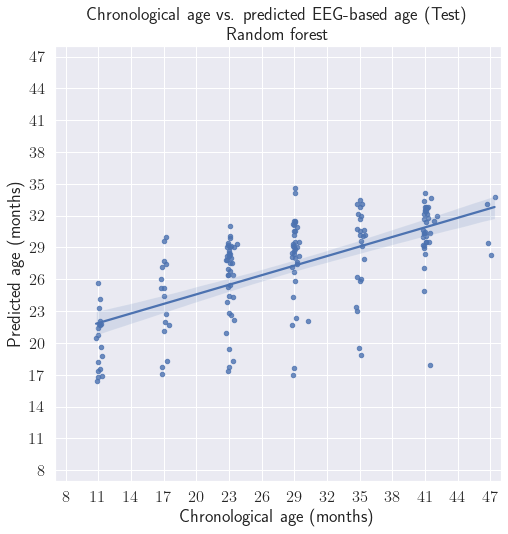

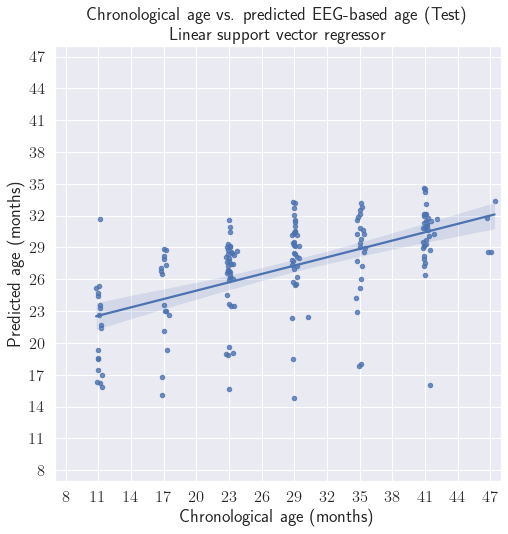

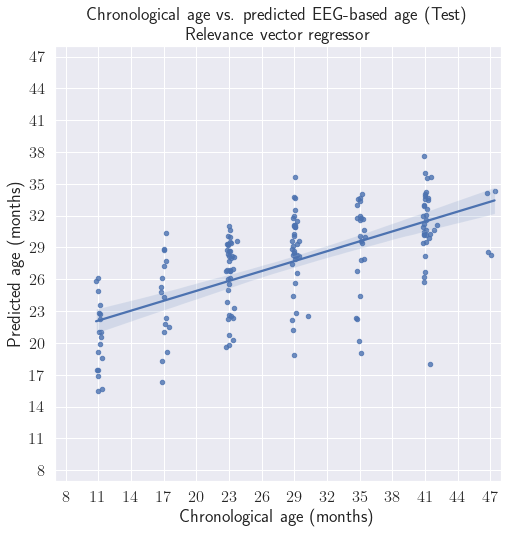

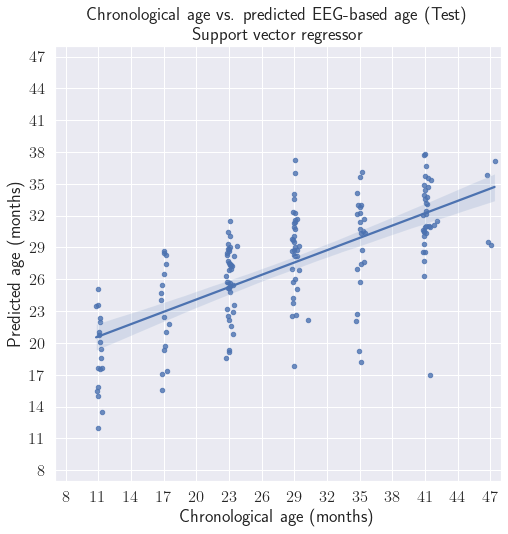

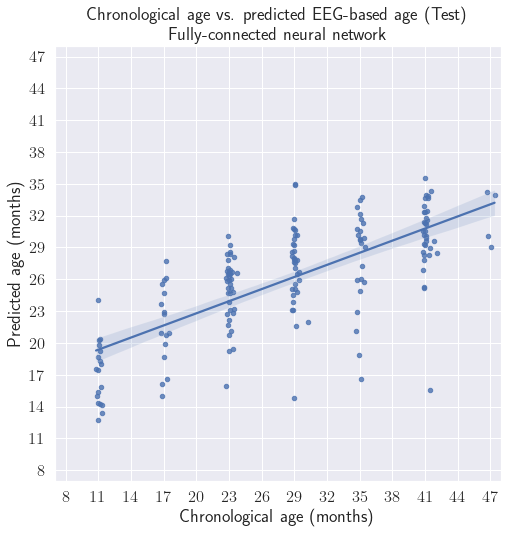

In [153]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/MachineLearning/True_Pred/"

for i, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(8,8))
    
    x = model_performance_test[model]['y_true'] # Test/Train
    y = model_performance_test[model]['y_pred'] # Test/Train
  
    sns.regplot(x=x, y=y, scatter_kws={'s':20}) 

    ax.set_xlim(7, 48)
    ax.set_ylim(7, 48)

    ax.set_xticks(np.arange(8, 48, 3.0))
    ax.set_yticks(np.arange(8, 48, 3.0))

    ax.grid()
    ax.set_axisbelow(True)

    ax.set_xlabel('Chronological age (months)')
    ax.set_ylabel('Predicted age (months)')
    ax.set_title(f'Chronological age vs. predicted EEG-based age (Test) \n {model_tile[i]}') # Test/Train
    
    plt.grid()
    
    fig_name = f"TEST_{os.path.splitext(model)[0]}_true_pred.pdf" # Test/Train
    fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

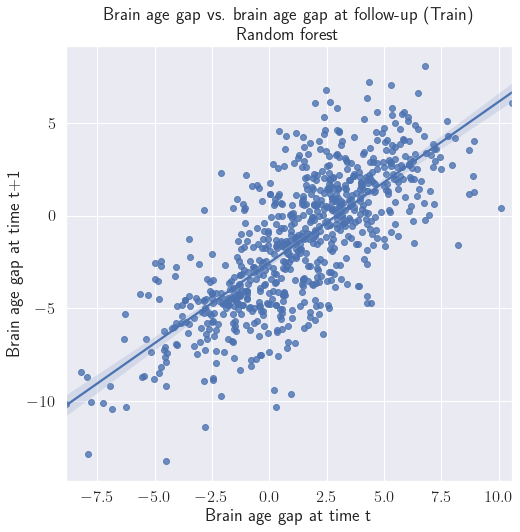

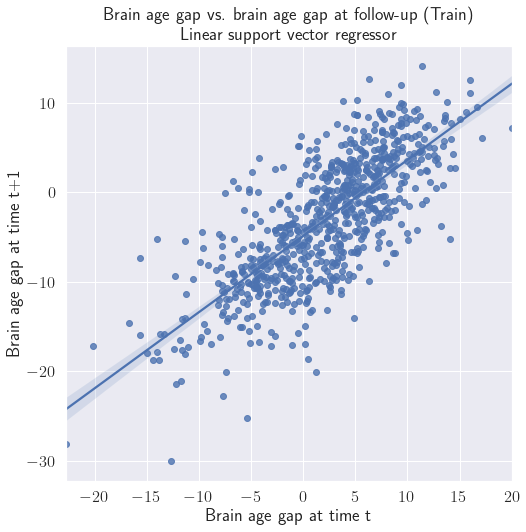

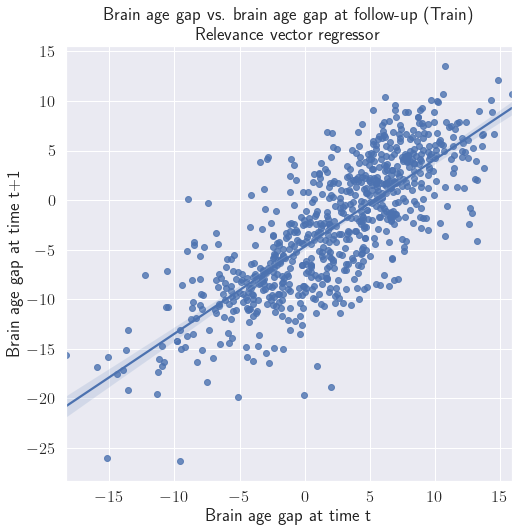

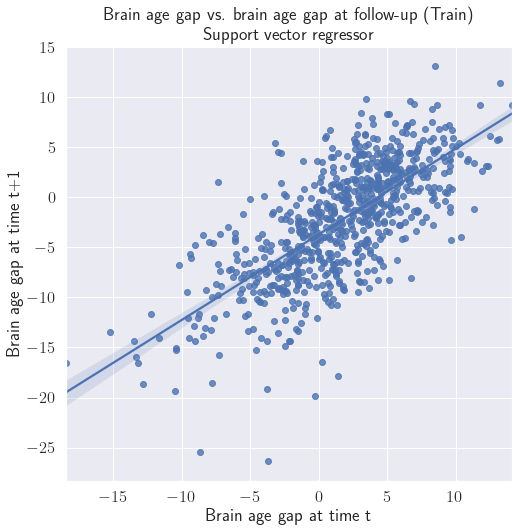

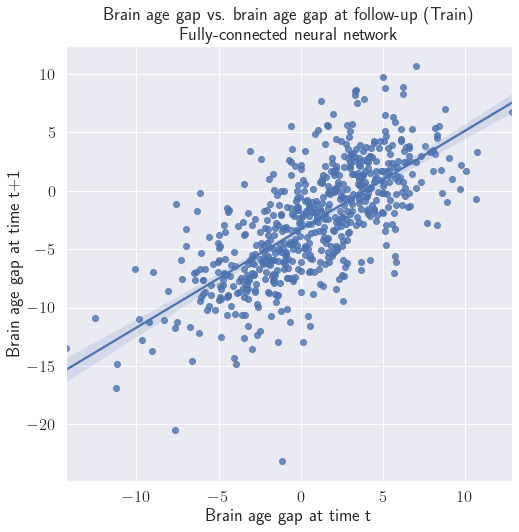

In [155]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/MachineLearning/ErrorN_ErrorN1/"

for i, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(8,8))
    
    x = model_performance_train_val[model]['errors_time_N'] # Test/Train
    y = model_performance_train_val[model]['errors_time_N1'] # Test/Train

#     sns.regplot(x=x, y=y, scatter_kws={'s':20}) 
    sns.regplot(x=x, y=y) 

    ax.grid()
    ax.set_axisbelow(True)

    ax.set_xlabel('Brain age gap at time t')
    ax.set_ylabel('Brain age gap at time t+1')
    ax.set_title(f'Brain age gap vs. brain age gap at follow-up (Train) \n {model_tile[i]}') # Test/Train
    
    plt.grid()
    
    fig_name = f"TRAIN_{os.path.splitext(model)[0]}_error_stability.pdf" # Test/Train
    fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

<ipython-input-157-ee059a7953bb>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8,8))


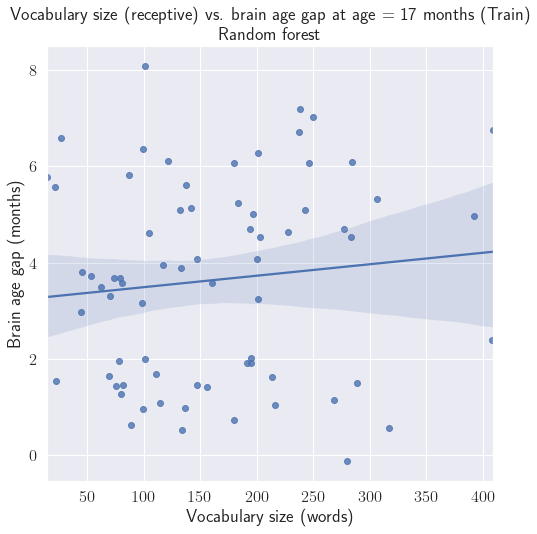

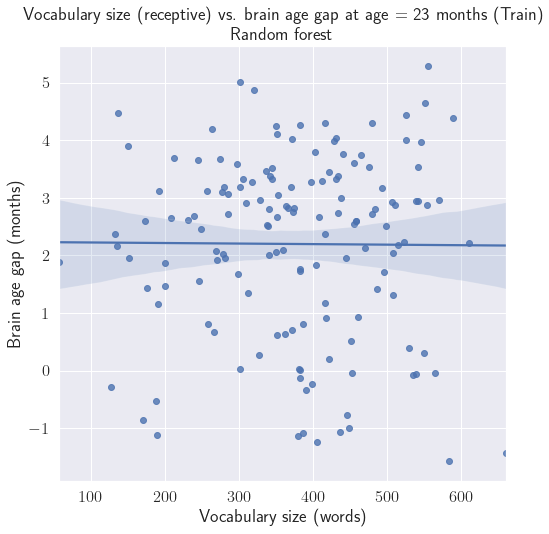

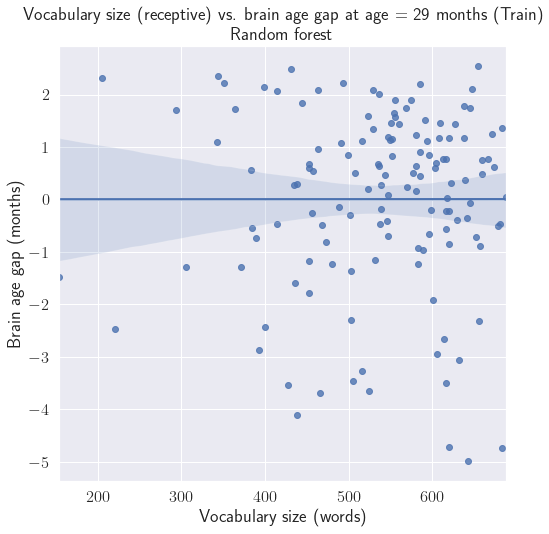

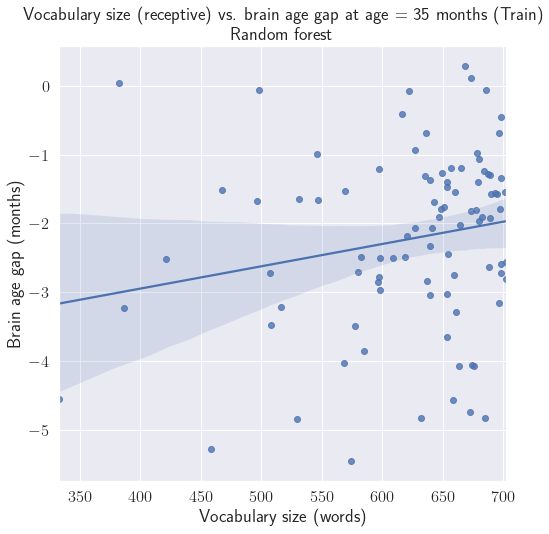

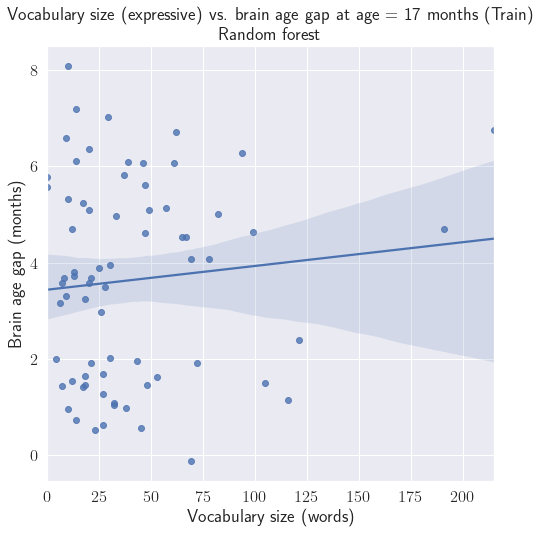

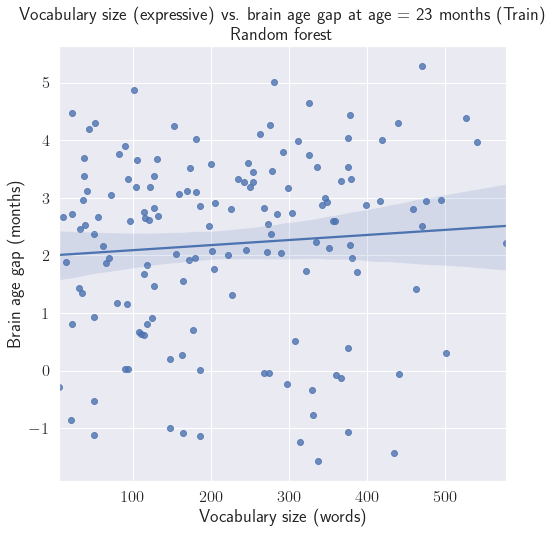

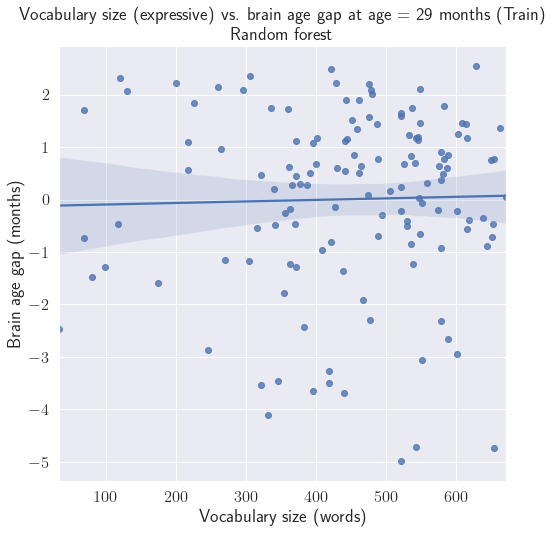

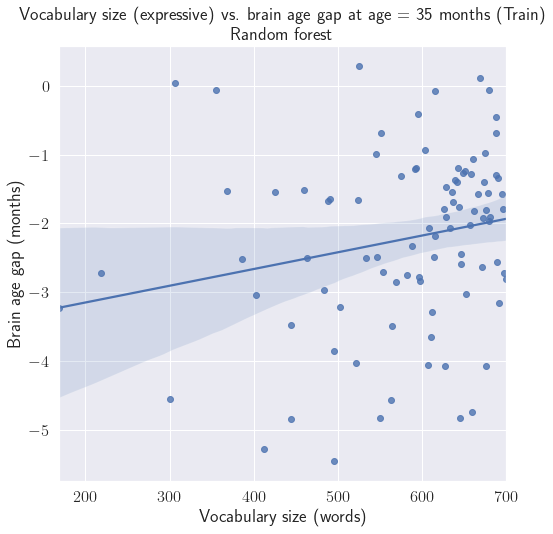

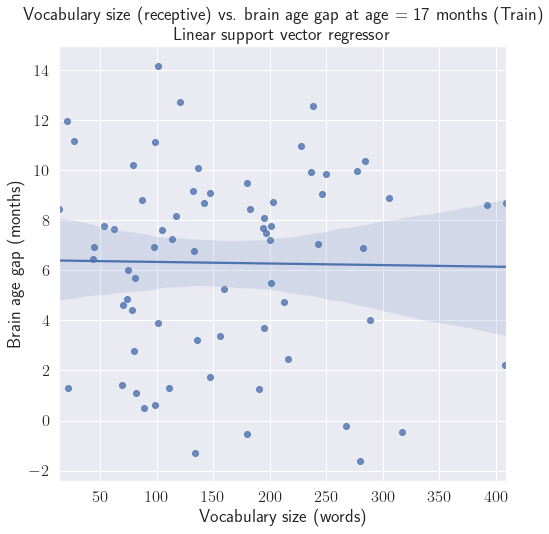

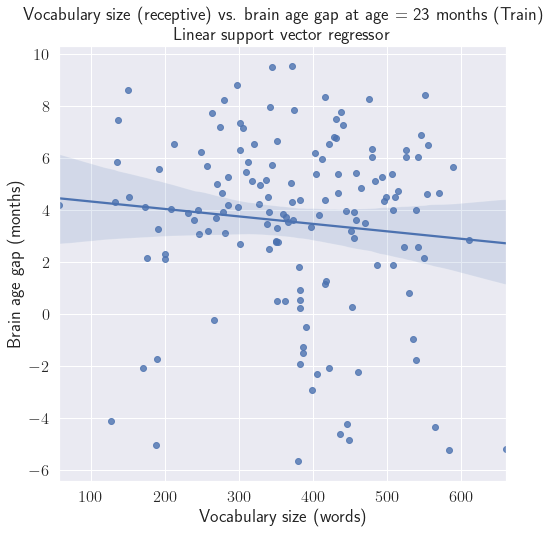

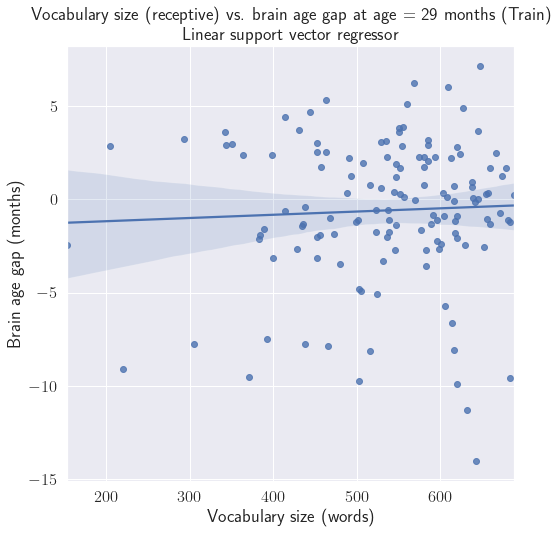

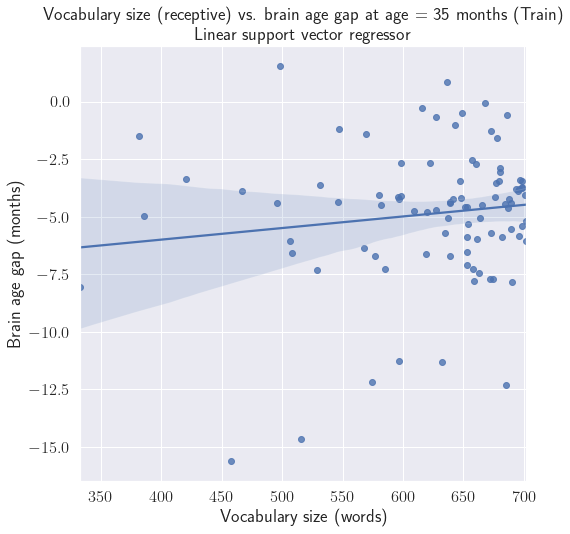

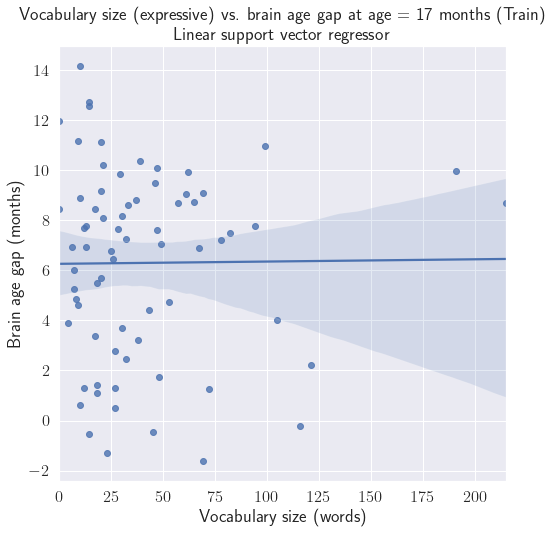

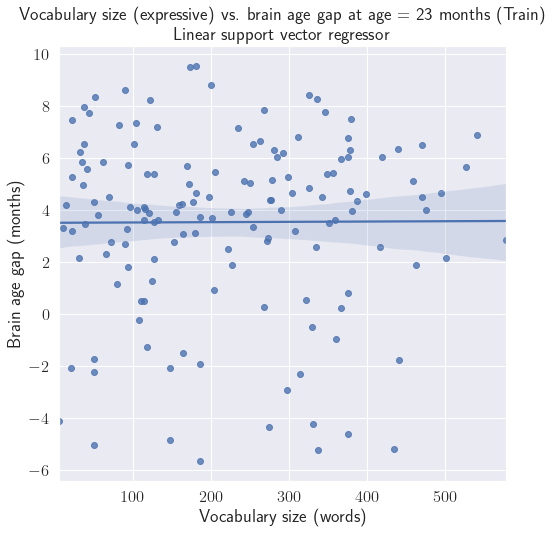

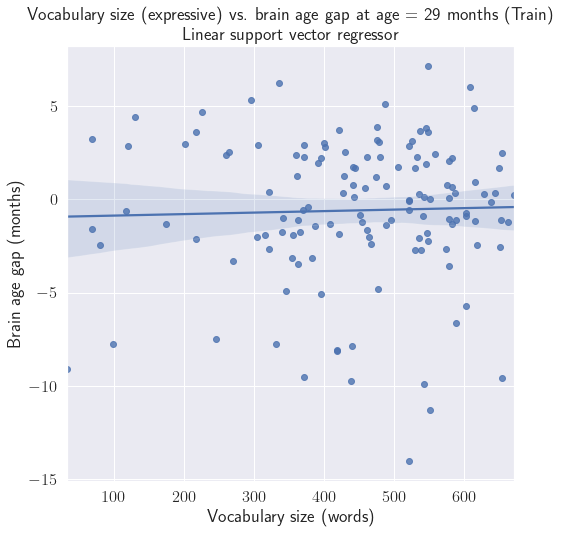

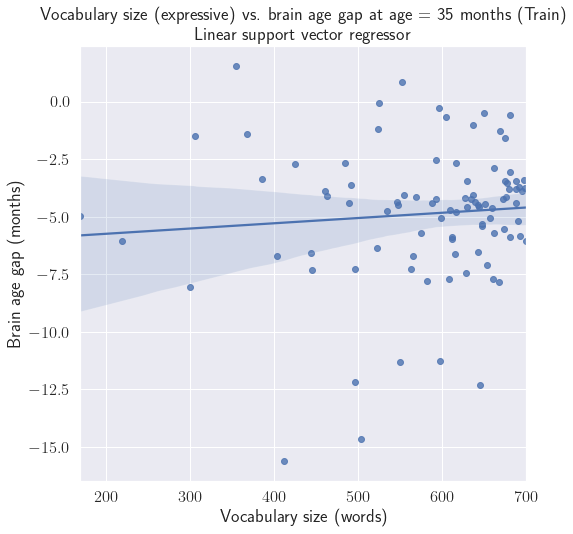

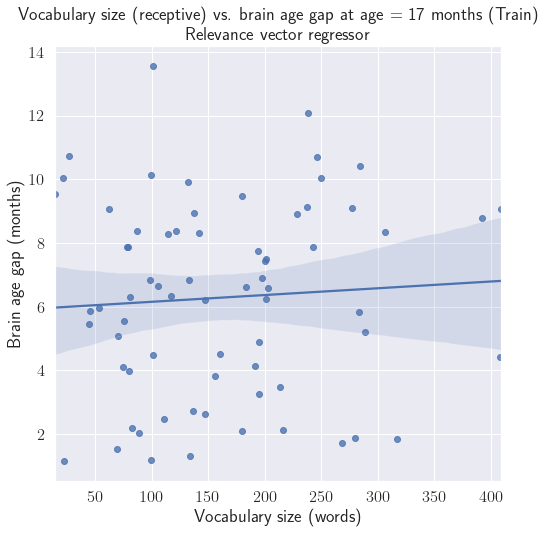

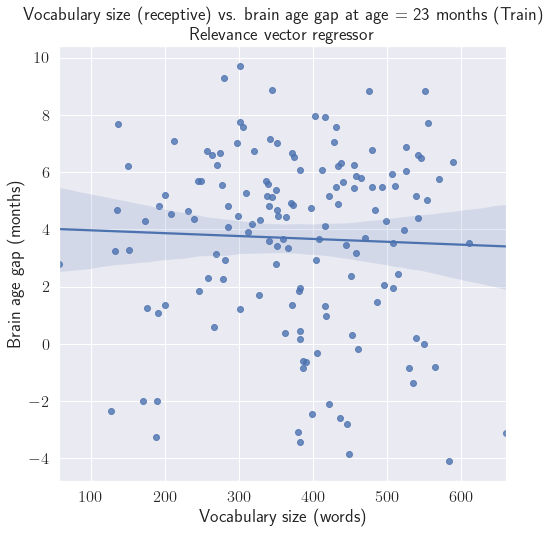

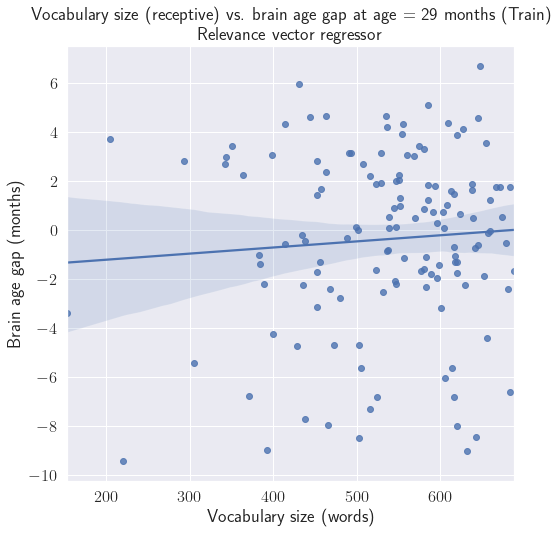

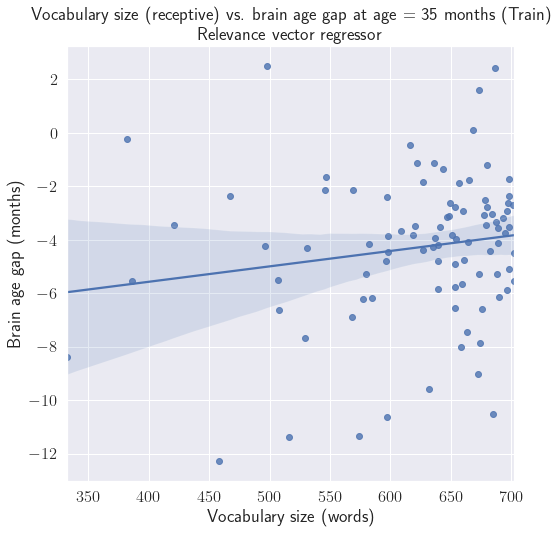

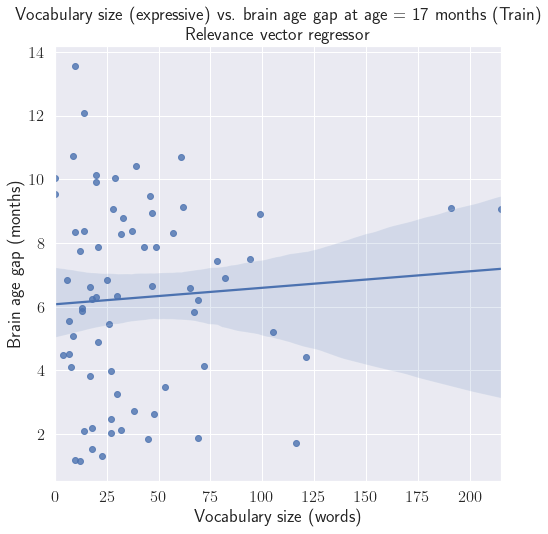

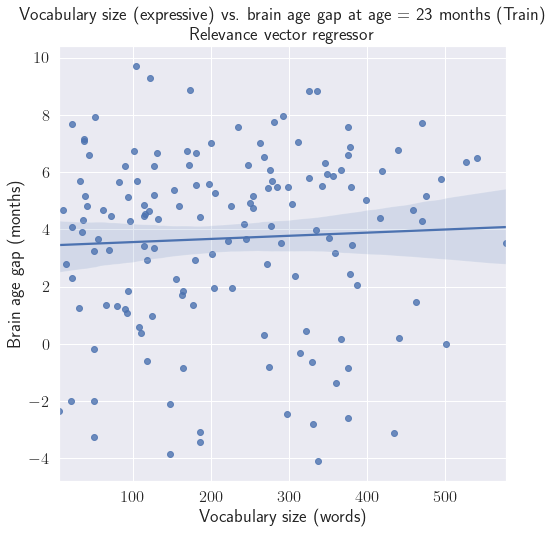

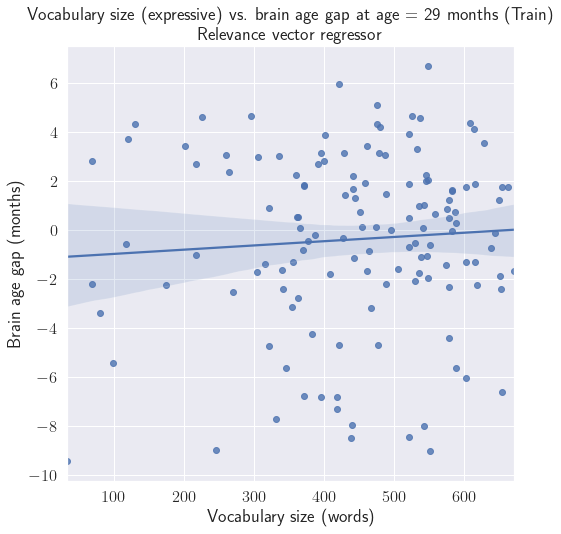

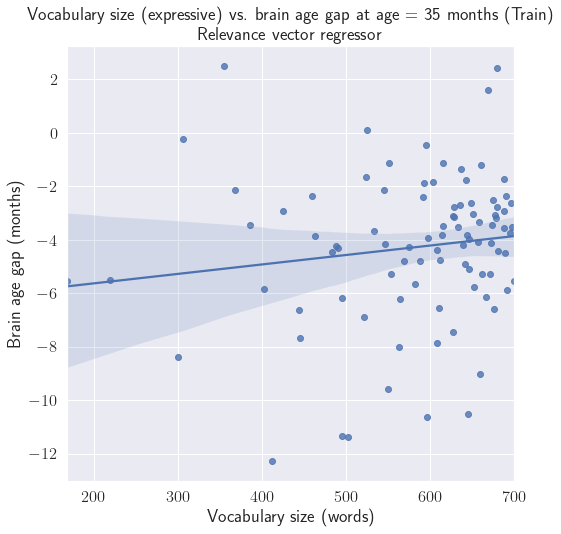

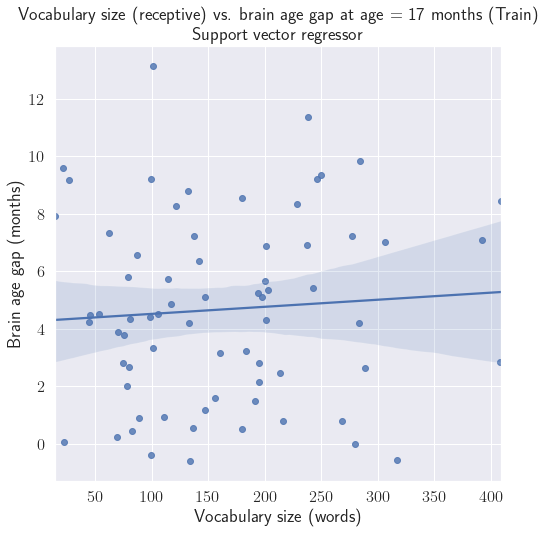

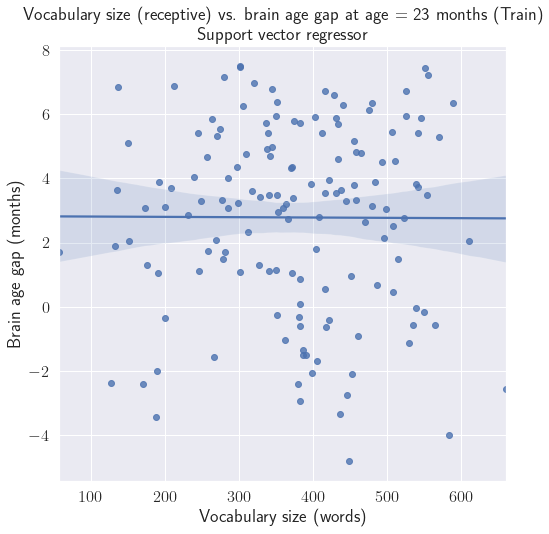

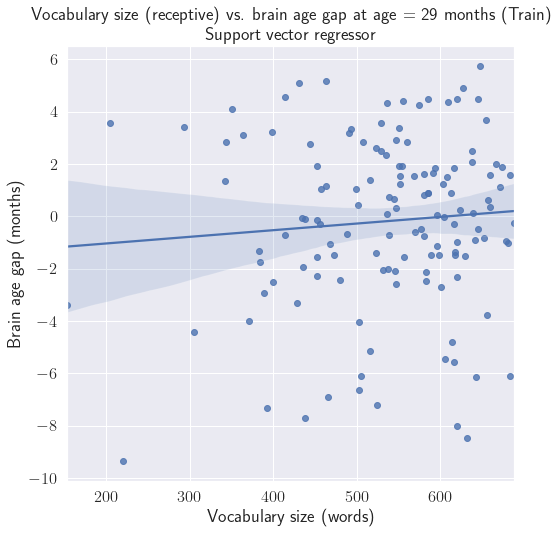

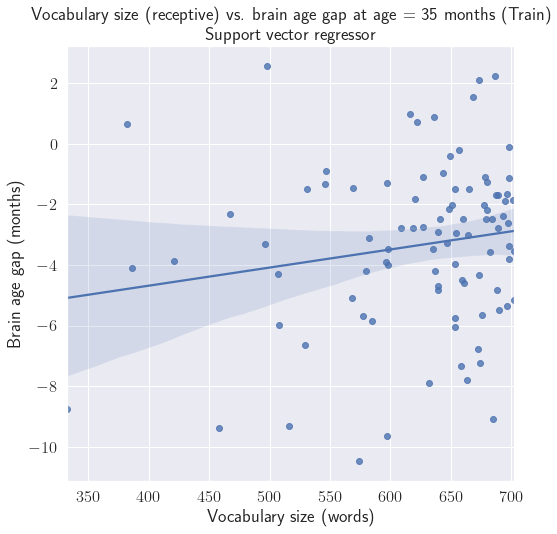

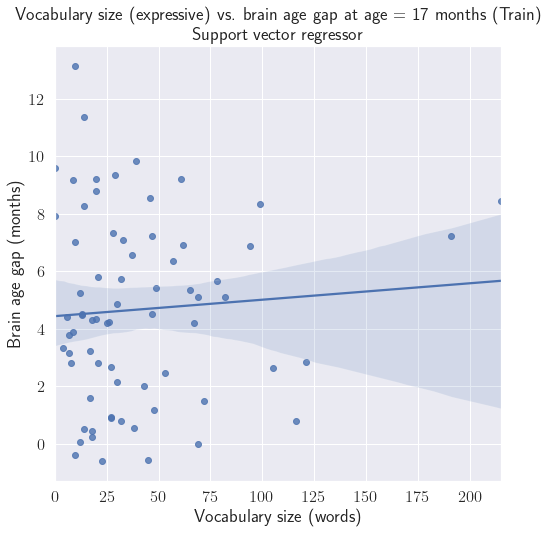

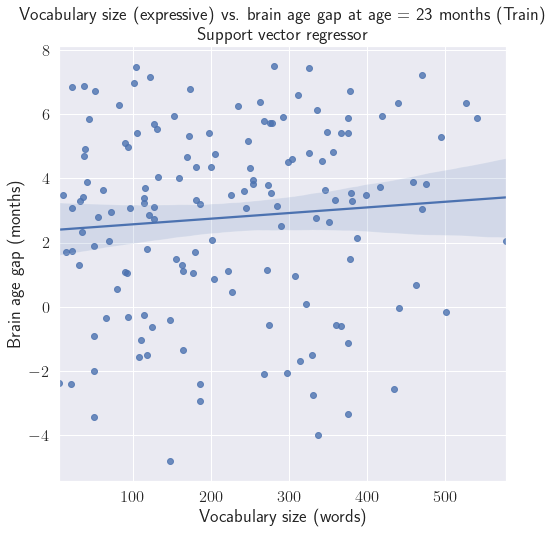

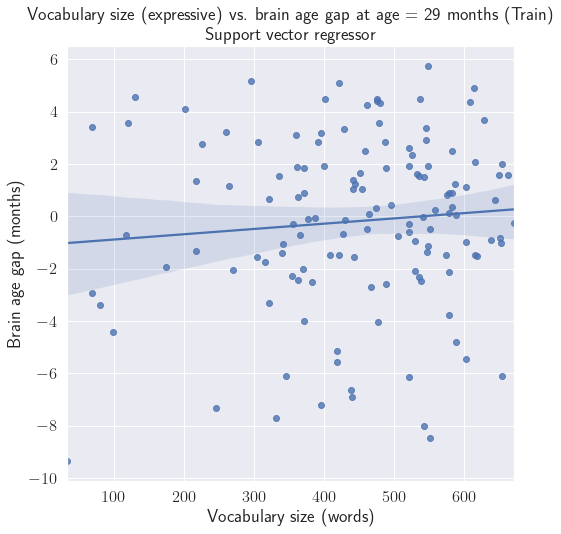

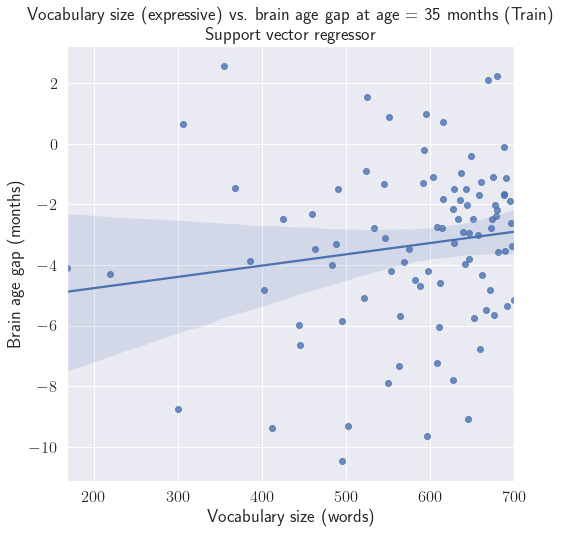

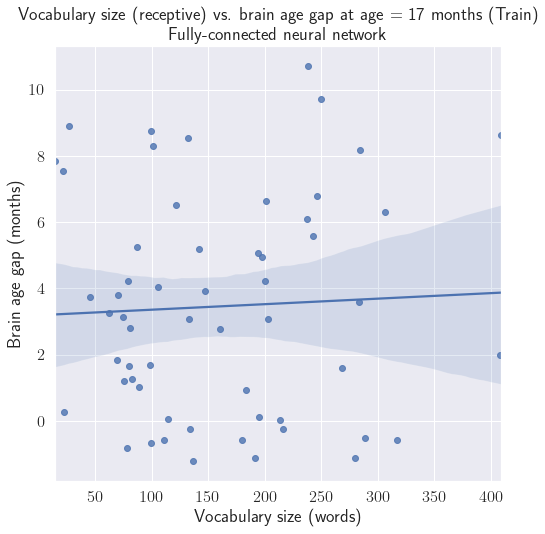

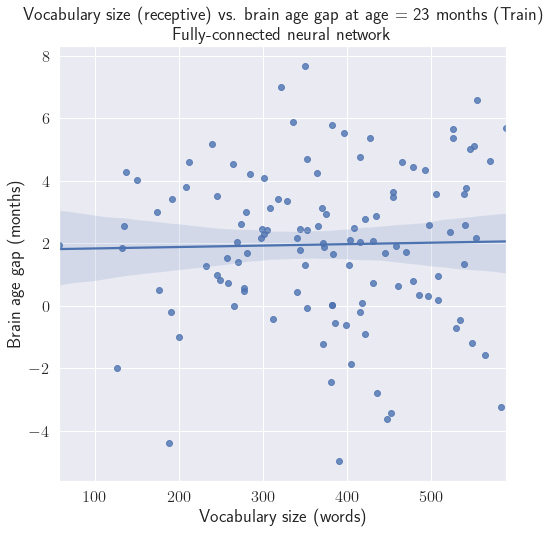

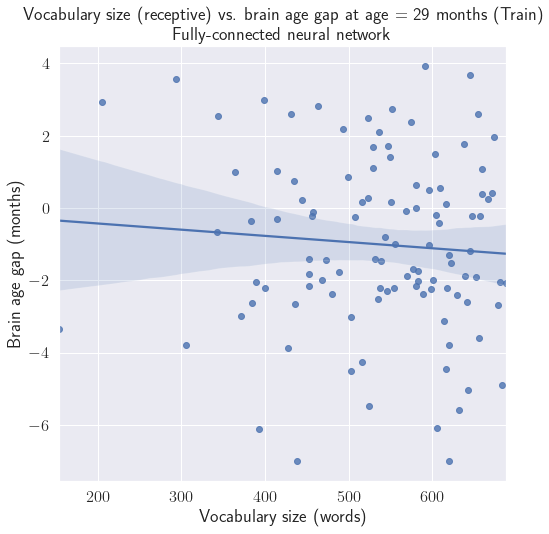

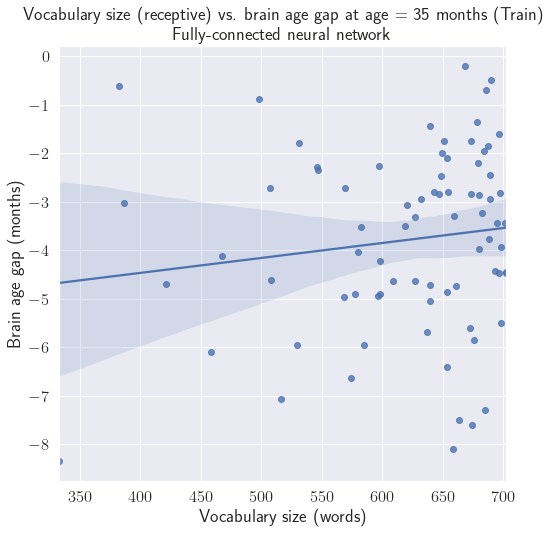

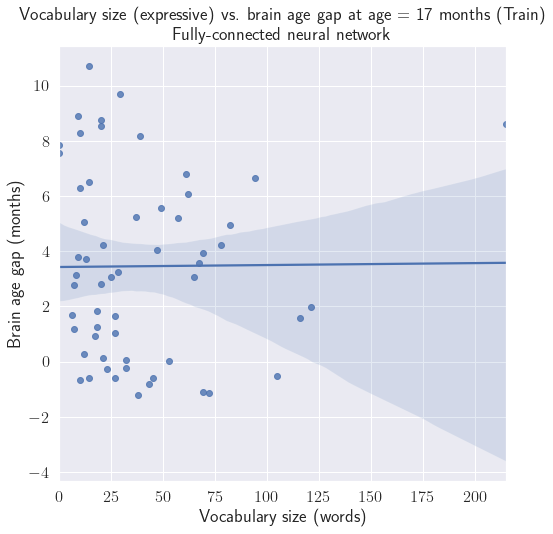

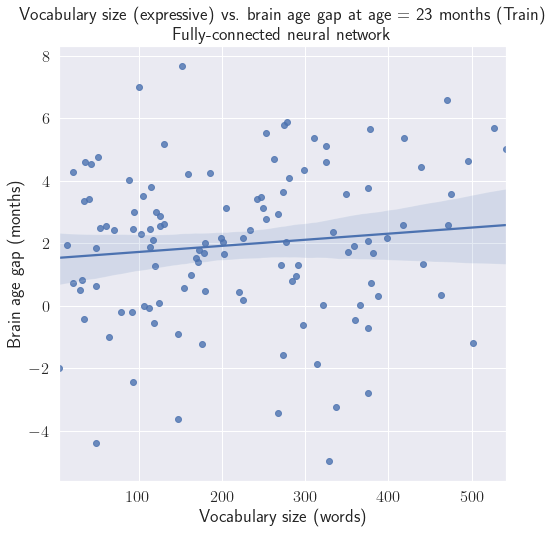

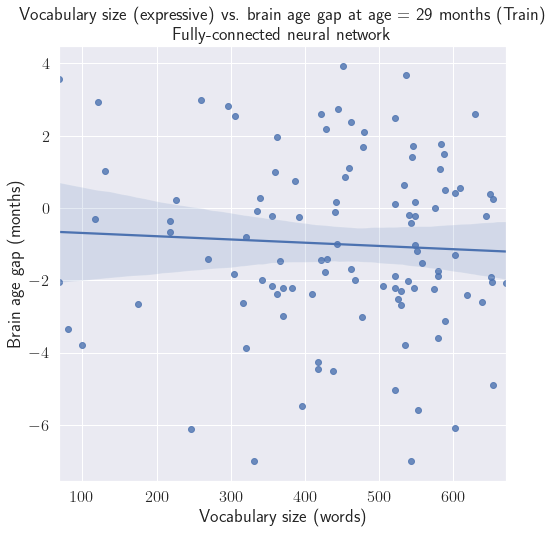

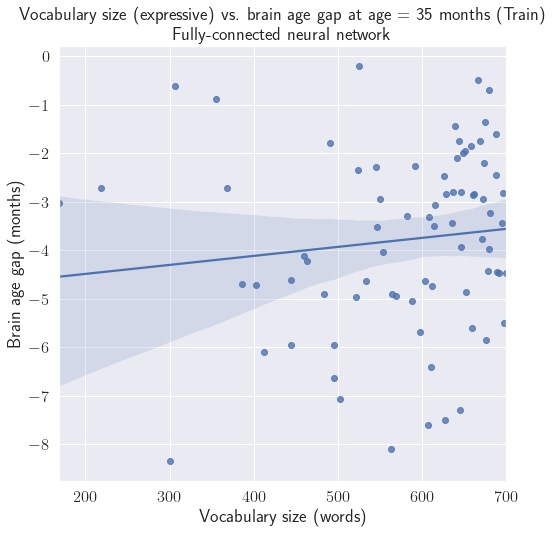

In [157]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/MachineLearning/"

categories = ["re", "pr"]
cat_names = ["receptive", "expressive"]

age_groups = [17, 23, 29, 35]
age_groups_path = ["Voc17/", "Voc23/", "Voc29/", "Voc35/"]

for i, model in enumerate(models):
    for j, category in enumerate(categories):
        for k, age_group in enumerate(age_groups):
            fig, ax = plt.subplots(figsize=(8,8))

            x = model_performance_train_val[model][f'vocabulary_sizes_{age_group}_{category}'] # Test/Train
            y = model_performance_train_val[model][f'brain_ages_{age_group}_{category}'] # Test/Train
            
            sns.regplot(x=x, y=y) 

            ax.grid()
            ax.set_axisbelow(True)

            ax.set_xlabel('Vocabulary size (words)')
            ax.set_ylabel('Brain age gap (months)')
            ax.set_title(f'Vocabulary size ({cat_names[j]}) vs. brain age gap at age = {age_group} months (Train) \n {model_tile[i]}') # Test/Train

            plt.grid()

            fig_name = f"TRAIN_{os.path.splitext(model)[0]}_vocabulary_{cat_names[j]}_{age_group}.pdf" # Test/Train
            fig.savefig(os.path.join(save_path + age_groups_path[k], fig_name), bbox_inches='tight')

# Old cells 

(Some) old cells are pasted below here, just in case they can be reused/referenced later.

In [ ]:
from sklearn.metrics import mean_absolute_error

y_true, y_pred = test_model_separate_epochs(loaded_model, X_test, y_test, codes_test)
mean_absolute_error(y_true, y_pred)

In [ ]:
# Bootstrapped
from sklearn.metrics import mean_absolute_error

y_true, y_pred, y_pred_epochs, y_pred_bootstrap = test_model_separate_epochs_bootstrapped(loaded_model, X_test, y_test, codes_test)
mean_absolute_error(y_true, y_pred)

In [ ]:
from statistics import stdev, mean

sd_list = [stdev(predictions) for predictions in y_pred_epochs]
print(f"Mean standard deviation for model (SD of epochs): {mean(sd_list)}")

In [ ]:
from statistics import stdev, mean

sd_list = [stdev(predictions) for predictions in y_pred_bootstrap]
print(f"Mean standard deviation for model (SD of final predictions, bootstrapped): {mean(sd_list)}")


In [ ]:
for i in range(len(y_pred)):
    CI = confidence_interval(y_pred[i], y_pred_bootstrap[i], 0.95)
    print(f"95% CI: [{CI[0]}, {CI[1]}]")
    print(f"Prediction: {y_pred[i]}")
#     print(f"Spread: {CI[1] - CI[0]}")

In [ ]:
desired_rate = 0.8

thresholds_epochs, retrieval_rates_epochs, index_epochs = determine_IQR_for_rate(y_pred, y_pred_epochs, max_threshold=15, step=-0.01, desired_rate=desired_rate)

print(f"Desired retrieval rate {desired_rate}, the IQR is approx. {thresholds_epochs[index_epochs]} for epochs method.")

In [ ]:
desired_rate = 0.8

thresholds_bootstrap, retrieval_rates_bootstrap, index_bootstrap = determine_IQR_for_rate(y_pred, y_pred_bootstrap, desired_rate=desired_rate)

print(f"Desired retrieval rate {desired_rate}, the IQR is approx. {thresholds_bootstrap[index_bootstrap]} for bootstrapped predictions.")

In [ ]:
corr, errors_time_N, errors_time_N1 = error_stability_averaged_epochs(loaded_model, X_test, y_test, codes_test)

In [ ]:
from sklearn.metrics import r2_score

rsquared = r2_score(y_true, y_pred)
print(f"R-squared: {rsquared:.3f}")

In [ ]:
voc_corr_17_pr, brain_ages_17_pr, vocabulary_sizes_17_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17, productive=True)
voc_corr_17_re, brain_ages_17_re, vocabulary_sizes_17_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17, productive=False)

voc_corr_23_pr, brain_ages_23_pr, vocabulary_sizes_23_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23, productive=True)
voc_corr_23_re, brain_ages_23_re, vocabulary_sizes_23_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23, productive=False)

voc_corr_29_pr, brain_ages_29_pr, vocabulary_sizes_29_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29, productive=True)
voc_corr_29_re, brain_ages_29_re, vocabulary_sizes_29_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29, productive=False)

voc_corr_35_pr, brain_ages_35_pr, vocabulary_sizes_35_pr = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35, productive=True)
voc_corr_35_re, brain_ages_35_re, vocabulary_sizes_35_re = correlation_brainage_vocabulary(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35, productive=False)

In [ ]:
print(voc_corr_17_pr)
print(voc_corr_17_re)

print(voc_corr_23_pr)
print(voc_corr_23_re)

print(voc_corr_29_pr)
print(voc_corr_29_re)

print(voc_corr_35_pr)
print(voc_corr_35_re)

In [93]:
dys_brainage_11, no_dys_brainage_11 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=11)
dys_brainage_17, no_dys_brainage_17 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=17)
dys_brainage_23, no_dys_brainage_23 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=23)
dys_brainage_29, no_dys_brainage_29 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=29)
dys_brainage_35, no_dys_brainage_35 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=35)
dys_brainage_41, no_dys_brainage_41 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=41)
dys_brainage_47, no_dys_brainage_47 = distributions_brainage_dyslexia(loaded_model, X_test, y_test, codes_test, agegroups_test, age_months=47)

In [95]:
no_dys_brainage_47

[]

In [97]:
from scipy.stats import kstest

print(mean(dys_brainage_11), mean(no_dys_brainage_11))
print(kstest(dys_brainage_11, no_dys_brainage_11, alternative='less'))

print(mean(dys_brainage_17), mean(no_dys_brainage_17))
print(kstest(dys_brainage_17, no_dys_brainage_17, alternative='less'))

print(mean(dys_brainage_23), mean(no_dys_brainage_23))
print(kstest(dys_brainage_23, no_dys_brainage_23, alternative='less'))

print(mean(dys_brainage_29), mean(no_dys_brainage_29))
print(kstest(dys_brainage_29, no_dys_brainage_29, alternative='less'))

print(mean(dys_brainage_35), mean(no_dys_brainage_35))
print(kstest(dys_brainage_35, no_dys_brainage_35, alternative='less'))

print(mean(dys_brainage_41), mean(no_dys_brainage_41))
print(kstest(dys_brainage_41, no_dys_brainage_41, alternative='less'))

# print(mean(dys_brainage_47), mean(no_dys_brainage_47))
# print(kstest(dys_brainage_47, no_dys_brainage_47, alternative='less'))

6.203871701897014 10.323787378179576
KstestResult(statistic=0.0, pvalue=1.0)
5.4426659901542385 7.569425054976366
KstestResult(statistic=0.10909090909090909, pvalue=0.8333333333333334)
2.587368295974517 3.319564463895242
KstestResult(statistic=0.041666666666666664, pvalue=0.96)
-1.1564821983463431 -0.9130791680645923
KstestResult(statistic=0.2077922077922078, pvalue=0.45605443246118876)
-4.239671597688853 -6.253137466112322
KstestResult(statistic=0.4666666666666667, pvalue=0.12512899896800825)
-12.218867569278023 -9.951455886757639
KstestResult(statistic=0.11180124223602485, pvalue=0.8086801257490913)


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x=retrieval_rates_epochs, y=thresholds_epochs)

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Retrieval rate')
ax.set_ylabel('IQR threshold value')
ax.set_title('The IQR score for retrieval rate (epochs)')

plt.grid()

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x=retrieval_rates_bootstrap, y=thresholds_bootstrap)

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Retrieval rate')
ax.set_ylabel('IQR threshold value')
ax.set_title('The IQR score for retrieval rate (bootstrapped)')

plt.grid()

In [ ]:
from statistics import stdev

%matplotlib inline

BA_gap = np.asarray(y_true) - np.asarray(y_pred)
SD = [stdev(predictions) for predictions in y_pred_epochs]

fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=BA_gap, y=SD)

# ax.set_ylim(0, 0.4) # MARK: Outliers might be outside this range

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Brain age gap')
ax.set_ylabel('Standard deviation')
ax.set_title('The SD vs. brain age gap (epochs)')

plt.grid()

In [ ]:
from statistics import stdev

%matplotlib inline

BA_gap = np.asarray(y_true) - np.asarray(y_pred)
SD = [stdev(predictions) for predictions in y_pred_bootstrap]

fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=BA_gap, y=SD)

ax.set_ylim(0, 0.4) # MARK: Outliers might be outside this range

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Brain age gap')
ax.set_ylabel('Standard deviation')
ax.set_title('The SD vs. brain age gap (bootstrapped)')

plt.grid()